<div style="text-align:center">
<h2>IBDA4311 - Computer Vision - CNN</h2>
<h3>Stefannus Christian 202000138</h3>
</div>

# Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.models as models
import torch.nn as nn
from torch import optim
from tqdm import tqdm

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

from time import perf_counter
from PIL import Image
from seaborn import heatmap
from os import listdir, makedirs, path
from re import sub
from shutil import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler

## Run In Collab

In [5]:
# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install medmnist
    from google.colab import drive
    drive.mount('/content/drive')
else: print("Not running on Google Colab.")

import medmnist
from medmnist import INFO

Not running on Google Colab.


# Check MedMNIST Version

In [6]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


# Download BloodMNIST Dataset

In [7]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 64
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Load Train and Test Dataset & Loader

In [8]:
# preprocessing
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# python -m medmnist save --flag=bloodmnist --folder=data/ --postfix=png

Using downloaded and verified file: C:\Users\chris\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\chris\.medmnist\bloodmnist.npz


# Display Train and Test Dataset

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\chris\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 

# Display Images

## Show The First 100 Train Dataset

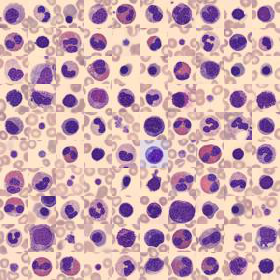

In [10]:
# montage
train_dataset.montage(length=10)

## Show Transformed Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


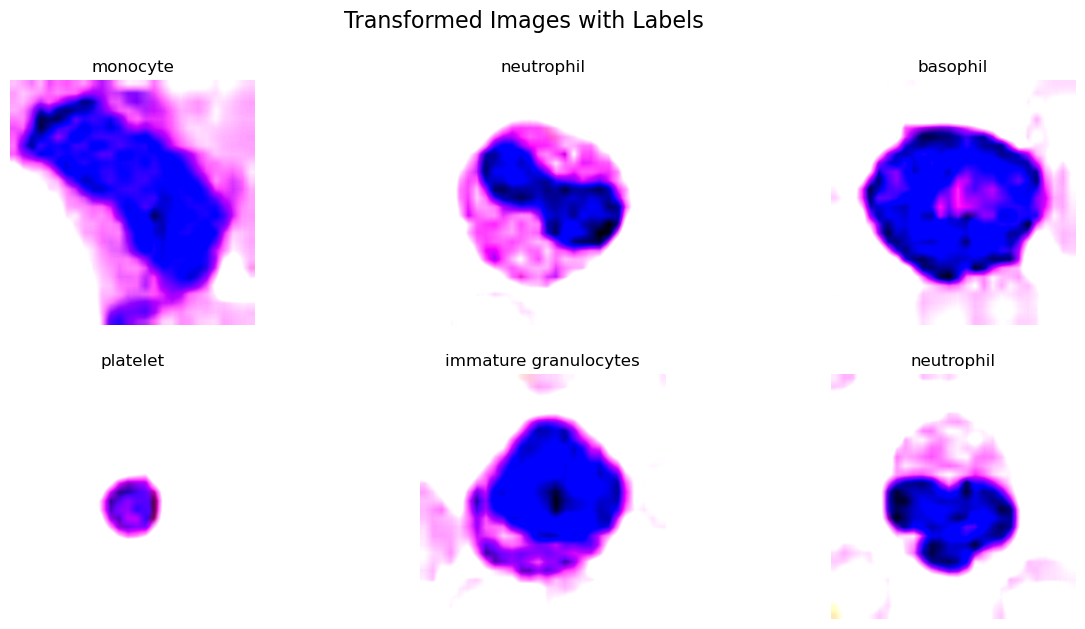

In [11]:
classes = ["basophil",
"eosinophil",
"erythroblast",
"immature granulocytes",
"lymphocyte",
"monocyte",
"neutrophil",
"platelet"]

def show_transformed_image(dataset, classes):
    loader = data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    fig.suptitle('Transformed Images with Labels', fontsize=16)

    for i in range(6):
        row, col = i // 3, i % 3
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        axs[row, col].imshow(img)
        axs[row, col].set_title(classes[labels[i].item()])
        axs[row, col].axis('off')

    plt.show()

show_transformed_image(train_dataset, classes)

# Set Device To CUDA or CPU

In [12]:
# Device configuration
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

def print_device_info():
    print(f"Device Count: {torch.cuda.device_count()}")
    print(f"Current Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

In [13]:
device = set_device()
print('Using device:', device)
print_device_info()

Using device: cuda
Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


# Make Necessary Directories

In [14]:
folders_to_create = ["csv", "confusion_matrix", "checkpoints", "evaluation", "models", "save_variables", "plots", "training_results","detailed_training_results","plots/training_loss","plots/training_accuracy"]
for folder in folders_to_create:
    makedirs(folder, exist_ok=True)
    print(f"Successfully Created Folder {folder}")

Successfully Created Folder csv
Successfully Created Folder confusion_matrix
Successfully Created Folder checkpoints
Successfully Created Folder evaluation
Successfully Created Folder models
Successfully Created Folder save_variables
Successfully Created Folder plots
Successfully Created Folder training_results
Successfully Created Folder detailed_training_results
Successfully Created Folder plots/training_loss
Successfully Created Folder plots/training_accuracy


# BloodMNISTClassifier Class

In [15]:
class BloodMNISTClassifier:
    def __init__(self, device, pretrained):
        self.device = device
        self.pretrained = pretrained

    def initialize_model(self, model_type):
        if model_type == 'alexnet':
            model = models.alexnet(pretrained=self.pretrained)
        elif model_type == 'vgg16':
            model = models.vgg16(pretrained=self.pretrained)
        elif model_type == 'googlenet':
            model = models.googlenet(pretrained=self.pretrained)
        elif model_type == 'resnet152':
            model = models.resnet152(pretrained=self.pretrained)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss()

        return model, optimizer, loss_fn

    def initialize_alexnet(self): return self.initialize_model('alexnet')

    def initialize_vgg16(self): return self.initialize_model('vgg16')

    def initialize_googlenet(self): return self.initialize_model('googlenet')

    def initialize_resnet152(self): return self.initialize_model('resnet152')

    def evaluate_model_on_test_set(self, model, test_loader):
        model.eval()
        total = 0
        predicted_correctly_on_epoch = 0

        with torch.no_grad():
            for images,labels in tqdm(test_loader):
                images = images.to(self.device)
                labels = labels.squeeze().long().to(self.device)
                total += labels.size(0)

                outputs = model(images)
                predicted_correctly_on_epoch += torch.eq(torch.argmax(outputs, dim=1), labels).sum().item()

        epoch_acc = 100.0 * (predicted_correctly_on_epoch / total)
        print(f"Testing dataset. Got {predicted_correctly_on_epoch} out of {total} images correctly ({epoch_acc:.3f}%)")
        return epoch_acc

    def save_checkpoint(self,model, epoch, optimizer, best_acc):
        model_name = type(model).__name__
        filename = f'drive/My Drive/IBDA4311/CNN/checkpoints/{model_name}_checkpoint.pth.tar' if IN_COLAB else f'checkpoints/{model_name}_checkpoint.pth.tar'

        state = {
            "epoch": epoch + 1,
            "model": model.state_dict(),
            "best_accuracy": best_acc,
            "optimizer": optimizer.state_dict()
        }

        torch.save(state, filename)

    def train_nn(self, model, train_loader, test_loader, criterion, optimizer, n_epochs, accumulation_steps=1,patience=5):
        best_acc = 0
        total_execution_time = 0
        scaler = GradScaler()

        early_stopping_counter = 0
        for epoch in range(n_epochs):
            start_time = perf_counter()
            print(f"Epoch number {epoch + 1}")

            predicted_correctly_on_epoch = 0
            model.train()
            running_loss = 0.0
            total = 0

            for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
                images, labels = images.to(self.device), labels.squeeze().long().to(self.device)
                total += labels.size(0)

                optimizer.zero_grad()

                with autocast():
                    outputs = model(images)
                    predicted_correctly_on_epoch += torch.eq(torch.argmax(outputs, dim=1), labels).sum().item()

                    loss = criterion(outputs, labels)
                    loss = loss / accumulation_steps

                scaler.scale(loss).backward()

                if (batch_idx + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100.00 * (predicted_correctly_on_epoch / total)

            print(f"Training dataset: Got {predicted_correctly_on_epoch} out of {total} images correctly ({epoch_acc:.3f}%). Epoch loss: {epoch_loss:.3f}")

            test_dataset_acc = self.evaluate_model_on_test_set(model, test_loader)
            if test_dataset_acc > best_acc:
                best_acc = test_dataset_acc
                early_stopping_counter = 0
                self.save_checkpoint(model, epoch, optimizer, best_acc)
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f"Epoch number {epoch + 1} takes {epoch_time:.4f} seconds")
                    print(f"Early stopping at epoch {epoch + 1} as validation accuracy did not improve for {patience} consecutive epochs.\n")
                    break

            end_time = perf_counter()
            epoch_time = end_time - start_time
            total_execution_time += epoch_time

            # Estimate remaining time
            remaining_epochs = n_epochs - (epoch + 1)
            estimated_remaining_time = remaining_epochs * epoch_time
            hours, remainder = divmod(estimated_remaining_time, 3600)
            minutes, seconds = divmod(remainder, 60)

            print(f"Epoch number {epoch + 1} takes {epoch_time:.4f} seconds")
            print(f"Estimated remaining time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds\n")

        print(f"{type(model).__name__} Training Finished")
        print(f"{type(model).__name__} Takes {total_execution_time} for {epoch + 1} epochs")
        return model

## Automate HTML Code for Model Training Results

In [16]:
def parse_training_results_string(training_results_string: str) -> dict[str]:
    epochs = []
    training_accs = []
    test_accs = []
    epoch_losses = []
    time_takens = []
    training_correct_predictions = []
    testing_correct_predictions = []

    # Split the string into lines
    lines = training_results_string.split("\n")

    # Iterate through each line
    for line in lines:
        # Skip empty lines
        if not line: continue

        split_line = line.split()

        # Check if it's an epoch line
        if line.startswith('Epoch number') and len(line) <= 15:
            # Extract epoch number
            epoch_number = line.split()[-1]
            epochs.append(epoch_number)

        # Check if it's a training accuracy line
        elif 'Training dataset:' in line:
            # Extract training accuracy
            training_correct = split_line[split_line.index("out")-1]+" / 11959"
            training_acc = split_line[-4][1:-2]

            # training_correct+=" / 11959"
            training_accs.append(training_acc)
            training_correct_predictions.append(training_correct)

            # Extract epoch loss
            epoch_loss = split_line[-1]
            epoch_losses.append(epoch_loss)

        # Check if it's a testing accuracy line
        elif 'Testing dataset. Got' in line:
            # Extract testing accuracy
            test_acc = split_line[-1][1:-1]
            testing_correct = split_line[3]+" / 3421"
            test_accs.append(test_acc)
            testing_correct_predictions.append(testing_correct)

        # Check if it's a time taken line
        elif 'takes' in line:
            # Extract time taken
            time_taken = split_line[-2]+" seconds"
            time_takens.append(time_taken)

        # Check if it's a model finished line
        elif 'Takes' in line:
            # Extract model name and total time
            model_name = split_line[0]
            total_time = split_line[2]+" seconds"

        # Check if it's a best epoch line
        elif 'Best Epoch' in line:
            best_epoch = split_line[-1]

    assert len(epochs) == len(training_accs) == len(test_accs) == len(epoch_losses) == len(time_takens) == len(training_correct_predictions) == len(testing_correct_predictions)

    return {
        'model_name': model_name,
        'epochs': epochs,
        'training_accs': training_accs,
        'test_accs': test_accs,
        'epoch_losses': epoch_losses,
        'time_takens': time_takens,
        'training_correct_predictions': training_correct_predictions,
        'testing_correct_predictions': testing_correct_predictions,
        'total_time': total_time,
        'best_epoch': best_epoch
    }

In [17]:
def create_model_training_results_html(training_results_dict: dict):
    model_name: str = training_results_dict['model_name']
    epochs: list[str] = training_results_dict['epochs']
    training_accs: list[str] = training_results_dict['training_accs']
    test_accs : list[str] = training_results_dict['test_accs']
    epoch_losses: list[str] = training_results_dict['epoch_losses']
    time_takens: list[str] = training_results_dict['time_takens']
    training_correct_predictions: list[str] = training_results_dict['training_correct_predictions']
    testing_correct_predictions: list[str] = training_results_dict['testing_correct_predictions']
    total_time: str = training_results_dict['total_time']

    css_style = """<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>
    """

    h1 = f"\n<h1>{model_name} Training Progress</h1>"
    thead = """
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    """

    tbody = "<tbody>\n"
    for epoch_ke, training_acc, test_acc, epoch_loss, time_taken, num_of_correct_training, num_of_correct_testing in zip(
        epochs, training_accs, test_accs, epoch_losses, time_takens, training_correct_predictions, testing_correct_predictions
    ):
        tbody += "      <tr>\n"
        tbody += "          <td>" + str(epoch_ke) + "</td>\n"
        tbody += "          <td>" + str(training_acc) + "</td>\n"
        tbody += "          <td>" + str(test_acc) + "</td>\n"
        tbody += "          <td>" + str(epoch_loss) + "</td>\n"
        tbody += "          <td>" + str(time_taken) + "</td>\n"
        tbody += "          <td>" + str(num_of_correct_training) + "</td>\n"
        tbody += "          <td>" + str(num_of_correct_testing) + "</td>\n"
        tbody += "      </tr>\n"

    tbody += "  </tbody>\n"
    tbody += "<table>"

    last_epoch = training_results_dict["epochs"][-1]
    h2 = f"\n<h2>{model_name} Training Summary</h2>\n"
    p1 = f"<p>{model_name} Training Finished</p>\n"
    p2 = f"<p>Total time taken for {last_epoch} epochs: {total_time}</p>\n\n"

    best_epoch = test_accs.index(max(test_accs))
    h3 = f"<h3>Best Results (Epoch {best_epoch+1})</h3>\n"

    best_training_correct_prediction = training_correct_predictions[int(best_epoch)].split("/")[0].strip().split(".")[0]
    best_testing_correct_prediction = testing_correct_predictions[int(best_epoch)].split("/")[0].strip().split(".")[0]
    best_training_acc = training_accs[int(best_epoch)]
    best_testing_acc = test_accs[int(best_epoch)]
    p3 = f"<p>Number of correctly predicted images on the training dataset: {best_training_correct_prediction} out of 11959 ({best_training_acc})</p>\n"
    p4 = f"<p>Number of correctly predicted images on the testing dataset: {best_testing_correct_prediction} out of 3421 ({best_testing_acc})</p>"

    html_code = css_style+h1+thead+tbody+h2+p1+p2+h3+p3+p4
    print(html_code)

## Train Models

In [18]:
device = set_device()
bmc = BloodMNISTClassifier(device, True)
num_epochs = 20

In [19]:
def print_model_checkpoint_details(model_checkpoint, model_name: str):
    print(model_name)
    print(f"Best Epoch {model_checkpoint['epoch']}")
    print(f"Best Test Accuracy {model_checkpoint['best_accuracy']}")

### Alexnet

In [20]:
# alexnet, alexnet_optimizer, alexnet_loss_fn = bmc.initialize_alexnet()
# bmc.train_nn(alexnet, train_loader, test_loader, alexnet_loss_fn, alexnet_optimizer, num_epochs)
alexnet_checkpoint_path = "drive/My Drive/IBDA4311/CNN/checkpoints/AlexNet_checkpoint.pth.tar" if IN_COLAB else "./checkpoints/AlexNet_checkpoint.pth.tar"
alextnet_checkpoint = torch.load(alexnet_checkpoint_path)
print_model_checkpoint_details(alextnet_checkpoint, "AlexNet")

AlexNet
Best Epoch 16
Best Test Accuracy 92.42911429406607


### Alexnet HTML Table Results

In [21]:
# Copy Paste This Results To A Markdown
alexnet_training_results_path = "drive/My Drive/IBDA4311/CNN/training_results/alexnet.txt" if IN_COLAB else "./training_results/alexnet.txt"
with open(alexnet_training_results_path, "r", encoding="utf8") as myfile: alexnet_training_results_string = myfile.read()
alexnet_training_results_dict = parse_training_results_string(alexnet_training_results_string)
create_model_training_results_html(alexnet_training_results_dict)

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>
    
<h1>AlexNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>38.632%</td>
          <td>59.193%</td>
          <td>2.218</td>
          <td>39.4606 seconds</td>
          <td>4620 / 11959</td>
          <td>2025 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>62.514%</td>
          <td>75.650%</td>
          <td>1.013</td>
          <td>40.5

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>

<h1>AlexNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>38.632%</td>
          <td>59.193%</td>
          <td>2.218</td>
          <td>39.4606 seconds</td>
          <td>4620 / 11959</td>
          <td>2025 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>62.514%</td>
          <td>75.650%</td>
          <td>1.013</td>
          <td>40.5973 seconds</td>
          <td>7476 / 11959</td>
          <td>2588 / 3421</td>
      </tr>
      <tr>
          <td>3</td>
          <td>73.535%</td>
          <td>80.035%</td>
          <td>0.713</td>
          <td>42.3755 seconds</td>
          <td>8794 / 11959</td>
          <td>2738 / 3421</td>
      </tr>
      <tr>
          <td>4</td>
          <td>76.955%</td>
          <td>82.110%</td>
          <td>0.637</td>
          <td>41.3634 seconds</td>
          <td>9203 / 11959</td>
          <td>2809 / 3421</td>
      </tr>
      <tr>
          <td>5</td>
          <td>83.477%</td>
          <td>80.094%</td>
          <td>0.452</td>
          <td>40.1043 seconds</td>
          <td>9983 / 11959</td>
          <td>2740 / 3421</td>
      </tr>
      <tr>
          <td>6</td>
          <td>85.551%</td>
          <td>82.871%</td>
          <td>0.408</td>
          <td>41.3924 seconds</td>
          <td>10231 / 11959</td>
          <td>2835 / 3421</td>
      </tr>
      <tr>
          <td>7</td>
          <td>86.688%</td>
          <td>89.155%</td>
          <td>0.373</td>
          <td>41.8132 seconds</td>
          <td>10367 / 11959</td>
          <td>3050 / 3421</td>
      </tr>
      <tr>
          <td>8</td>
          <td>89.364%</td>
          <td>88.804%</td>
          <td>0.306</td>
          <td>40.8683 seconds</td>
          <td>10687 / 11959</td>
          <td>3038 / 3421</td>
      </tr>
      <tr>
          <td>9</td>
          <td>89.096%</td>
          <td>89.155%</td>
          <td>0.302</td>
          <td>41.7695 seconds</td>
          <td>10655 / 11959</td>
          <td>3050 / 3421</td>
      </tr>
      <tr>
          <td>10</td>
          <td>89.648%</td>
          <td>87.986%</td>
          <td>0.303</td>
          <td>41.1767 seconds</td>
          <td>10721 / 11959</td>
          <td>3010 / 3421</td>
      </tr>
      <tr>
          <td>11</td>
          <td>90.392%</td>
          <td>89.740%</td>
          <td>0.279</td>
          <td>42.2663 seconds</td>
          <td>10810 / 11959</td>
          <td>3070 / 3421</td>
      </tr>
      <tr>
          <td>12</td>
          <td>91.429%</td>
          <td>91.172%</td>
          <td>0.259</td>
          <td>42.6077 seconds</td>
          <td>10934 / 11959</td>
          <td>3119 / 3421</td>
      </tr>
      <tr>
          <td>13</td>
          <td>92.106%</td>
          <td>91.026%</td>
          <td>0.228</td>
          <td>41.7363 seconds</td>
          <td>11015 / 11959</td>
          <td>3114 / 3421</td>
      </tr>
      <tr>
          <td>14</td>
          <td>92.432%</td>
          <td>91.172%</td>
          <td>0.228</td>
          <td>41.4474 seconds</td>
          <td>11054 / 11959</td>
          <td>3119 / 3421</td>
      </tr>
      <tr>
          <td>15</td>
          <td>92.675%</td>
          <td>90.208%</td>
          <td>0.228</td>
          <td>41.1528 seconds</td>
          <td>11083 / 11959</td>
          <td>3086 / 3421</td>
      </tr>
      <tr>
          <td>16</td>
          <td>92.851%</td>
          <td>92.429%</td>
          <td>0.211</td>
          <td>42.2065 seconds</td>
          <td>11104 / 11959</td>
          <td>3162 / 3421</td>
      </tr>
      <tr>
          <td>17</td>
          <td>93.110%</td>
          <td>91.260%</td>
          <td>0.204</td>
          <td>41.1621 seconds</td>
          <td>11135 / 11959</td>
          <td>3122 / 3421</td>
      </tr>
      <tr>
          <td>18</td>
          <td>93.812%</td>
          <td>92.312%</td>
          <td>0.176</td>
          <td>41.2608 seconds</td>
          <td>11219 / 11959</td>
          <td>3158 / 3421</td>
      </tr>
      <tr>
          <td>19</td>
          <td>94.506%</td>
          <td>89.944%</td>
          <td>0.159</td>
          <td>40.9763 seconds</td>
          <td>11302 / 11959</td>
          <td>3077 / 3421</td>
      </tr>
      <tr>
          <td>20</td>
          <td>94.464%</td>
          <td>92.108%</td>
          <td>0.169</td>
          <td>38.7660 seconds</td>
          <td>11297 / 11959</td>
          <td>3151 / 3421</td>
      </tr>
  </tbody>
<table>
<h2>AlexNet Training Summary</h2>
<p>AlexNet Training Finished</p>
<p>Total time taken for 20 epochs: 824.5035679999997 seconds</p>

<h3>Best Results (Epoch 16)</h3>
<p>Number of correctly predicted images on the training dataset: 11104 out of 11959 (92.851%)</p>
<p>Number of correctly predicted images on the testing dataset: 3162 out of 3421 (92.429%)</p>


### VGG16

In [22]:
# vgg16, vgg16_optimizer, vgg16_loss_fn = bmc.initialize_vgg16()
# bmc.train_nn(vgg16, train_loader, test_loader, vgg16_loss_fn, vgg16_optimizer, num_epochs)
vgg16_checkpoint_path = "drive/My Drive/IBDA4311/CNN/checkpoints/VGG_checkpoint.pth.tar" if IN_COLAB else "./checkpoints/VGG_checkpoint.pth.tar"
vgg16_checkpoint = torch.load(vgg16_checkpoint_path)
print_model_checkpoint_details(vgg16_checkpoint, "VGG16")

VGG16
Best Epoch 20
Best Test Accuracy 91.581408944753


### VGG16 HTML Table Results

In [23]:
# Copy Paste This Results To A Markdown
vgg16_training_results_path = "drive/My Drive/IBDA4311/CNN/training_results/vgg16.txt" if IN_COLAB else "./training_results/vgg16.txt"
with open(vgg16_training_results_path, "r", encoding="utf8") as myfile: vgg16_training_results_string = myfile.read()
vgg16_training_results_dict = parse_training_results_string(vgg16_training_results_string)
create_model_training_results_html(vgg16_training_results_dict)

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>
    
<h1>VGG Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>32.243%</td>
          <td>57.498%</td>
          <td>2.969</td>
          <td>2099.4936 seconds</td>
          <td>3856 / 11959</td>
          <td>1967 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>64.855%</td>
          <td>72.610%</td>
          <td>0.909</td>
          <td>2085.5

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>

<h1>VGG Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>32.243%</td>
          <td>57.498%</td>
          <td>2.969</td>
          <td>2099.4936 seconds</td>
          <td>3856 / 11959</td>
          <td>1967 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>64.855%</td>
          <td>72.610%</td>
          <td>0.909</td>
          <td>2085.5803 seconds</td>
          <td>7756 / 11959</td>
          <td>2484 / 3421</td>
      </tr>
      <tr>
          <td>3</td>
          <td>75.056%</td>
          <td>79.275%</td>
          <td>0.677</td>
          <td>2086.2697 seconds</td>
          <td>8976 / 11959</td>
          <td>2712 / 3421</td>
      </tr>
      <tr>
          <td>4</td>
          <td>80.308%</td>
          <td>81.964%</td>
          <td>0.537</td>
          <td>2086.5559 seconds</td>
          <td>9604 / 11959</td>
          <td>2804 / 3421</td>
      </tr>
      <tr>
          <td>5</td>
          <td>82.507%</td>
          <td>84.098%</td>
          <td>0.487</td>
          <td>2086.8438 seconds</td>
          <td>9867 / 11959</td>
          <td>2877 / 3421</td>
      </tr>
      <tr>
          <td>6</td>
          <td>84.037%</td>
          <td>85.735%</td>
          <td>0.442</td>
          <td>2085.1692 seconds</td>
          <td>10050 / 11959</td>
          <td>2933 / 3421</td>
      </tr>
      <tr>
          <td>7</td>
          <td>85.827%</td>
          <td>86.554%</td>
          <td>0.396</td>
          <td>2086.6121 seconds</td>
          <td>10264 / 11959</td>
          <td>2961 / 3421</td>
      </tr>
      <tr>
          <td>8</td>
          <td>86.136%</td>
          <td>86.495%</td>
          <td>0.384</td>
          <td>2081.4910 seconds</td>
          <td>10301 / 11959</td>
          <td>2959 / 3421</td>
      </tr>
      <tr>
          <td>9</td>
          <td>86.922%</td>
          <td>87.518%</td>
          <td>0.374</td>
          <td>2071.1792 seconds</td>
          <td>10395 / 11959</td>
          <td>2994 / 3421</td>
      </tr>
      <tr>
          <td>10</td>
          <td>87.691%</td>
          <td>86.524%</td>
          <td>0.348</td>
          <td>2067.9848 seconds</td>
          <td>10487 / 11959</td>
          <td>2960 / 3421</td>
      </tr>
      <tr>
          <td>11</td>
          <td>88.845%</td>
          <td>88.395%</td>
          <td>0.322</td>
          <td>2071.0857 seconds</td>
          <td>10625 / 11959</td>
          <td>3024 / 3421</td>
      </tr>
      <tr>
          <td>12</td>
          <td>89.606%</td>
          <td>86.144%</td>
          <td>0.293</td>
          <td>2067.3992 seconds</td>
          <td>10716 / 11959</td>
          <td>2947 / 3421</td>
      </tr>
      <tr>
          <td>13</td>
          <td>90.451%</td>
          <td>90.032%</td>
          <td>0.274</td>
          <td>2070.6817 seconds</td>
          <td>10817 / 11959</td>
          <td>3080 / 3421</td>
      </tr>
      <tr>
          <td>14</td>
          <td>91.019%</td>
          <td>88.746%</td>
          <td>0.251</td>
          <td>2066.7878 seconds</td>
          <td>10885 / 11959</td>
          <td>3036 / 3421</td>
      </tr>
      <tr>
          <td>15</td>
          <td>90.467%</td>
          <td>91.201%</td>
          <td>0.276</td>
          <td>2070.4407 seconds</td>
          <td>10819 / 11959</td>
          <td>3120 / 3421</td>
      </tr>
      <tr>
          <td>16</td>
          <td>90.969%</td>
          <td>90.821%</td>
          <td>0.265</td>
          <td>2064.9923 seconds</td>
          <td>10879 / 11959</td>
          <td>3107 / 3421</td>
      </tr>
      <tr>
          <td>17</td>
          <td>91.881%</td>
          <td>91.026%</td>
          <td>0.233</td>
          <td>2063.5873 seconds</td>
          <td>10988 / 11959</td>
          <td>3114 / 3421</td>
      </tr>
      <tr>
          <td>18</td>
          <td>92.056%</td>
          <td>91.143%</td>
          <td>0.233</td>
          <td>2061.6086 seconds</td>
          <td>11009 / 11959</td>
          <td>3118 / 3421</td>
      </tr>
      <tr>
          <td>19</td>
          <td>92.934%</td>
          <td>89.506%</td>
          <td>0.205</td>
          <td>2062.2351 seconds</td>
          <td>11114 / 11959</td>
          <td>3062 / 3421</td>
      </tr>
      <tr>
          <td>20</td>
          <td>92.550%</td>
          <td>91.581%</td>
          <td>0.218</td>
          <td>2064.8768 seconds</td>
          <td>11068 / 11959</td>
          <td>3133 / 3421</td>
      </tr>
  </tbody>
<table>
<h2>VGG Training Summary</h2>
<p>VGG Training Finished</p>
<p>Total time taken for 20 epochs: 41500.875232599996 seconds</p>

<h3>Best Results (Epoch 20)</h3>
<p>Number of correctly predicted images on the training dataset: 11068 out of 11959 (92.550%)</p>
<p>Number of correctly predicted images on the testing dataset: 3133 out of 3421 (91.581%)</p>


### GoogLeNet

In [24]:
# googlenet, googlenet_optimizer, googlenet_loss_fn = bmc.initialize_googlenet()
# bmc.train_nn(googlenet, train_loader, test_loader, googlenet_loss_fn, googlenet_optimizer, num_epochs)
googlenet_checkpoint_path = "drive/My Drive/IBDA4311/CNN/checkpoints/GoogLeNet_checkpoint.pth.tar" if IN_COLAB else "./checkpoints/GoogLeNet_checkpoint.pth.tar"
googLeNet_checkpoint = torch.load(googlenet_checkpoint_path)
print_model_checkpoint_details(googLeNet_checkpoint, "GoogLeNet")

GoogLeNet
Best Epoch 17
Best Test Accuracy 95.61531715872552


### GoogLeNet HTML Table Results

In [25]:
# Copy Paste This Results To A Markdown
googlenet_training_results_path = "drive/My Drive/IBDA4311/CNN/training_results/googlenet.txt" if IN_COLAB else "./training_results/googlenet.txt"
with open(googlenet_training_results_path, "r", encoding="utf8") as myfile: googlenet_training_results_string = myfile.read()
googlenet_training_results_dict = parse_training_results_string(googlenet_training_results_string)
create_model_training_results_html(googlenet_training_results_dict)

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>
    
<h1>GoogLeNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>88.093%</td>
          <td>81.818%</td>
          <td>0.411</td>
          <td>326.2763 seconds</td>
          <td>10535 / 11959</td>
          <td>2799 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>93.678%</td>
          <td>93.715%</td>
          <td>0.179</td>
          <td>

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>

<h1>GoogLeNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>88.093%</td>
          <td>81.818%</td>
          <td>0.411</td>
          <td>326.2763 seconds</td>
          <td>10535 / 11959</td>
          <td>2799 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>93.678%</td>
          <td>93.715%</td>
          <td>0.179</td>
          <td>293.4796 seconds</td>
          <td>11203 / 11959</td>
          <td>3206 / 3421</td>
      </tr>
      <tr>
          <td>3</td>
          <td>95.317%</td>
          <td>89.652%</td>
          <td>0.133</td>
          <td>287.9745 seconds</td>
          <td>11399 / 11959</td>
          <td>3067 / 3421</td>
      </tr>
      <tr>
          <td>4</td>
          <td>96.195%</td>
          <td>92.575%</td>
          <td>0.110</td>
          <td>301.5344 seconds</td>
          <td>11504 / 11959</td>
          <td>3167 / 3421</td>
      </tr>
      <tr>
          <td>5</td>
          <td>96.873%</td>
          <td>90.441%</td>
          <td>0.085</td>
          <td>337.1208 seconds</td>
          <td>11585 / 11959</td>
          <td>3094 / 3421</td>
      </tr>
      <tr>
          <td>6</td>
          <td>97.023%</td>
          <td>92.605%</td>
          <td>0.083</td>
          <td>334.6676 seconds</td>
          <td>11603 / 11959</td>
          <td>3168 / 3421</td>
      </tr>
      <tr>
          <td>7</td>
          <td>97.190%</td>
          <td>93.832%</td>
          <td>0.078</td>
          <td>369.9289 seconds</td>
          <td>11623 / 11959</td>
          <td>3210 / 3421</td>
      </tr>
      <tr>
          <td>8</td>
          <td>97.826%</td>
          <td>92.838%</td>
          <td>0.064</td>
          <td>329.0888 seconds</td>
          <td>11699 / 11959</td>
          <td>3176 / 3421</td>
      </tr>
      <tr>
          <td>9</td>
          <td>98.002%</td>
          <td>95.031%</td>
          <td>0.058</td>
          <td>307.4826 seconds</td>
          <td>11720 / 11959</td>
          <td>3251 / 3421</td>
      </tr>
      <tr>
          <td>10</td>
          <td>98.344%</td>
          <td>86.261%</td>
          <td>0.049</td>
          <td>365.0440 seconds</td>
          <td>11761 / 11959</td>
          <td>2951 / 3421</td>
      </tr>
      <tr>
          <td>11</td>
          <td>98.252%</td>
          <td>94.475%</td>
          <td>0.049</td>
          <td>350.3846 seconds</td>
          <td>11750 / 11959</td>
          <td>3232 / 3421</td>
      </tr>
      <tr>
          <td>12</td>
          <td>98.336%</td>
          <td>92.049%</td>
          <td>0.050</td>
          <td>357.4531 seconds</td>
          <td>11760 / 11959</td>
          <td>3149 / 3421</td>
      </tr>
      <tr>
          <td>13</td>
          <td>98.478%</td>
          <td>93.365%</td>
          <td>0.043</td>
          <td>343.5486 seconds</td>
          <td>11777 / 11959</td>
          <td>3194 / 3421</td>
      </tr>
      <tr>
          <td>14</td>
          <td>98.821%</td>
          <td>95.060%</td>
          <td>0.034</td>
          <td>316.3420 seconds</td>
          <td>11818 / 11959</td>
          <td>3252 / 3421</td>
      </tr>
      <tr>
          <td>15</td>
          <td>98.512%</td>
          <td>95.411%</td>
          <td>0.042</td>
          <td>348.9063 seconds</td>
          <td>11781 / 11959</td>
          <td>3264 / 3421</td>
      </tr>
      <tr>
          <td>16</td>
          <td>98.670%</td>
          <td>94.826%</td>
          <td>0.035</td>
          <td>350.1700 seconds</td>
          <td>11800 / 11959</td>
          <td>3244 / 3421</td>
      </tr>
      <tr>
          <td>17</td>
          <td>98.662%</td>
          <td>95.615%</td>
          <td>0.038</td>
          <td>332.5141 seconds</td>
          <td>11799 / 11959</td>
          <td>3271 / 3421</td>
      </tr>
      <tr>
          <td>18</td>
          <td>98.696%</td>
          <td>93.920%</td>
          <td>0.037</td>
          <td>322.4345 seconds</td>
          <td>11803 / 11959</td>
          <td>3213 / 3421</td>
      </tr>
      <tr>
          <td>19</td>
          <td>98.871%</td>
          <td>94.651%</td>
          <td>0.032</td>
          <td>337.6814 seconds</td>
          <td>11824 / 11959</td>
          <td>3238 / 3421</td>
      </tr>
      <tr>
          <td>20</td>
          <td>98.704%</td>
          <td>92.341%</td>
          <td>0.035</td>
          <td>383.4861 seconds</td>
          <td>11804 / 11959</td>
          <td>1.76it/s]Testing / 3421</td>
      </tr>
  </tbody>
<table>
<h2>GoogLeNet Training Summary</h2>
<p>GoogLeNet Training Finished</p>
<p>Total time taken for 20 epochs: 6695.518283900001 seconds</p>

<h3>Best Results (Epoch 17)</h3>
<p>Number of correctly predicted images on the training dataset: 11799 out of 11959 (98.662%)</p>
<p>Number of correctly predicted images on the testing dataset: 3271 out of 3421 (95.615%)</p>


### ResNet152

In [26]:
# resnet152, resnet152_optimizer, resnet152_loss_fn = bmc.initialize_resnet152()
# bmc.train_nn(resnet152, train_loader, test_loader, resnet152_loss_fn, resnet152_optimizer, num_epochs)
resnet152_checkpoint_path = "drive/My Drive/IBDA4311/CNN/checkpoints/ResNet_checkpoint.pth.tar" if IN_COLAB else "./checkpoints/ResNet_checkpoint.pth.tar"
resnet152_checkpoint = torch.load(resnet152_checkpoint_path)
print_model_checkpoint_details(resnet152_checkpoint, "ResNet152")

ResNet152
Best Epoch 18
Best Test Accuracy 95.81993569131832


### ResNet152 HTML Table Results

In [27]:
# Copy Paste This Results To A Markdown
resnet152_training_results_path = "drive/My Drive/IBDA4311/CNN/training_results/resnet152.txt" if IN_COLAB else "./training_results/resnet152.txt"
with open(resnet152_training_results_path, "r", encoding="utf8") as myfile: resnet152_training_results_string = myfile.read()
resnet152_training_results_dict = parse_training_results_string(resnet152_training_results_string)
create_model_training_results_html(resnet152_training_results_dict)

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>
    
<h1>ResNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>83.694%</td>
          <td>76.235%</td>
          <td>0.593</td>
          <td>3286.9461 seconds</td>
          <td>10009 / 11959</td>
          <td>2608 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>92.625%</td>
          <td>88.103%</td>
          <td>0.220</td>
          <td>32

<style>
    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }
</style>

<h1>ResNet Training Progress</h1>
<table>
    <thead>
        <tr>
            <th>Epoch</th>
            <th>Training Accuracy</th>
            <th>Testing Accuracy</th>
            <th>Epoch Loss</th>
            <th>Time Taken</th>
            <th>Training Correct Predictions</th>
            <th>Testing Correct Predictions</th>
        </tr>
    </thead>
    <tbody>
      <tr>
          <td>1</td>
          <td>83.694%</td>
          <td>76.235%</td>
          <td>0.593</td>
          <td>3286.9461 seconds</td>
          <td>10009 / 11959</td>
          <td>2608 / 3421</td>
      </tr>
      <tr>
          <td>2</td>
          <td>92.625%</td>
          <td>88.103%</td>
          <td>0.220</td>
          <td>3287.9194 seconds</td>
          <td>11077 / 11959</td>
          <td>3014 / 3421</td>
      </tr>
      <tr>
          <td>3</td>
          <td>94.038%</td>
          <td>90.588%</td>
          <td>0.175</td>
          <td>3269.5932 seconds</td>
          <td>11246 / 11959</td>
          <td>3099 / 3421</td>
      </tr>
      <tr>
          <td>4</td>
          <td>94.188%</td>
          <td>92.663%</td>
          <td>0.161</td>
          <td>3262.9102 seconds</td>
          <td>11264 / 11959</td>
          <td>3170 / 3421</td>
      </tr>
      <tr>
          <td>5</td>
          <td>95.409%</td>
          <td>91.552%</td>
          <td>0.130</td>
          <td>3262.6587 seconds</td>
          <td>11410 / 11959</td>
          <td>3132 / 3421</td>
      </tr>
      <tr>
          <td>6</td>
          <td>95.936%</td>
          <td>93.861%</td>
          <td>0.117</td>
          <td>3264.3279 seconds</td>
          <td>11473 / 11959</td>
          <td>3211 / 3421</td>
      </tr>
      <tr>
          <td>7</td>
          <td>96.455%</td>
          <td>92.955%</td>
          <td>0.100</td>
          <td>3264.2908 seconds</td>
          <td>11535 / 11959</td>
          <td>3180 / 3421</td>
      </tr>
      <tr>
          <td>8</td>
          <td>96.864%</td>
          <td>93.715%</td>
          <td>0.089</td>
          <td>3264.3879 seconds</td>
          <td>11584 / 11959</td>
          <td>3206 / 3421</td>
      </tr>
      <tr>
          <td>9</td>
          <td>96.973%</td>
          <td>94.037%</td>
          <td>0.087</td>
          <td>3259.3173 seconds</td>
          <td>11597 / 11959</td>
          <td>3217 / 3421</td>
      </tr>
      <tr>
          <td>10</td>
          <td>97.483%</td>
          <td>92.838%</td>
          <td>0.071</td>
          <td>3256.1158 seconds</td>
          <td>11658 / 11959</td>
          <td>3176 / 3421</td>
      </tr>
      <tr>
          <td>11</td>
          <td>97.608%</td>
          <td>94.154%</td>
          <td>0.068</td>
          <td>3963.8104 seconds</td>
          <td>11673 / 11959</td>
          <td>3221 / 3421</td>
      </tr>
      <tr>
          <td>12</td>
          <td>98.386%</td>
          <td>93.861%</td>
          <td>0.049</td>
          <td>3724.6694 seconds</td>
          <td>11766 / 11959</td>
          <td>3211 / 3421</td>
      </tr>
      <tr>
          <td>13</td>
          <td>97.918%</td>
          <td>94.738%</td>
          <td>0.060</td>
          <td>3810.3535 seconds</td>
          <td>11710 / 11959</td>
          <td>3241 / 3421</td>
      </tr>
      <tr>
          <td>14</td>
          <td>98.971%</td>
          <td>94.241%</td>
          <td>0.030</td>
          <td>3730.0715 seconds</td>
          <td>11836 / 11959</td>
          <td>3224 / 3421</td>
      </tr>
      <tr>
          <td>15</td>
          <td>98.319%</td>
          <td>87.197%</td>
          <td>0.048</td>
          <td>3597.5689 seconds</td>
          <td>11758 / 11959</td>
          <td>2983 / 3421</td>
      </tr>
      <tr>
          <td>16</td>
          <td>98.052%</td>
          <td>92.400%</td>
          <td>0.057</td>
          <td>3548.4326 seconds</td>
          <td>11726 / 11959</td>
          <td>3161 / 3421</td>
      </tr>
      <tr>
          <td>17</td>
          <td>98.211%</td>
          <td>92.312%</td>
          <td>0.049</td>
          <td>3548.1285 seconds</td>
          <td>11745 / 11959</td>
          <td>3158 / 3421</td>
      </tr>
      <tr>
          <td>18</td>
          <td>98.930%</td>
          <td>95.820%</td>
          <td>0.031</td>
          <td>3550.7229 seconds</td>
          <td>11831 / 11959</td>
          <td>3278 / 3421</td>
      </tr>
      <tr>
          <td>19</td>
          <td>98.946%</td>
          <td>92.985%</td>
          <td>0.030</td>
          <td>3548.1708 seconds</td>
          <td>11833 / 11959</td>
          <td>3181 / 3421</td>
      </tr>
      <tr>
          <td>20</td>
          <td>98.428%</td>
          <td>94.212%</td>
          <td>0.042</td>
          <td>3550.6406 seconds</td>
          <td>11771 / 11959</td>
          <td>3223 / 3421</td>
      </tr>
  </tbody>
<table>
<h2>ResNet Training Summary</h2>
<p>ResNet Training Finished</p>
<p>Total time taken for 20 epochs: 69251.036423450023 seconds</p>

<h3>Best Results (Epoch 18)</h3>
<p>Number of correctly predicted images on the training dataset: 11831 out of 11959 (98.930%)</p>
<p>Number of correctly predicted images on the testing dataset: 3278 out of 3421 (95.820%)</p>


In [28]:
def categorize_bloodmnist_data(image_folder_path: str):
    bloodmnist_datas = listdir(image_folder_path)
    total_data_to_move = len(bloodmnist_datas)
    print(f"There are a total of {total_data_to_move} images to copy.")
    start_time = perf_counter()
    for filename in bloodmnist_datas:
        data_type = sub(r'\d', '', filename.split("_")[0])
        source_path = image_folder_path+"/"+filename
        destination_path = "data/"+data_type+"/"+filename
        copy(source_path, destination_path)
        print(f"Copying file {filename} from {image_folder_path} to {destination_path} successful!")
    end_time = perf_counter()
    execution_time = end_time - start_time
    print(f"Moving {total_data_to_move} images takes {execution_time:.4f} seconds")

if not IN_COLAB:
    image_folder_path = "./data/bloodmnist"
    # categorize_bloodmnist_data(image_folder_path)

In [29]:
def make_best_models():
    checkpoints_folder_path ="drive/My Drive/IBDA4311/CNN/checkpoints/" if IN_COLAB else "./checkpoints/"

    for checkpoint_model in listdir(checkpoints_folder_path):
        checkpoint_file = f"{checkpoints_folder_path}{checkpoint_model}"
        checkpoint = torch.load(checkpoint_file)

        # Get the model name from the checkpoint file
        model_name = checkpoint_model.split("_")[0]

        # Instantiate the correct model based on the model name
        if model_name == "GoogLeNet":
            model = models.googlenet(pretrained=True)
        elif model_name == "ResNet":
            model = models.resnet152(pretrained=True)
        elif model_name == "VGG":
            model = models.vgg16(pretrained=True)
        elif model_name == "AlexNet":
            model = models.alexnet(pretrained=True)

        # Load the state_dict from the checkpoint into the model
        model.load_state_dict(checkpoint["model"], strict=False)

        # Save the model with a new name
        torch.save(model, f"models/{model_name}_best_model.pth")

# make_best_models()

In [30]:
def classify(model, image_transforms, image_path, true_label, classes, device):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    image = image.to(device)

    output = model(image)
    _, predicted = torch.max(output.data, 1)

    correct_label = classes[true_label]
    predicted_label = classes[predicted.item()]
    return correct_label, predicted_label

def make_models_csv_files(device):
    test_folder_path = "./data/test/"
    best_model_folder_path = "./models/"

    for best_model in listdir(best_model_folder_path):
        start_time = perf_counter()
        model_name = best_model.split("_")[0]
        print(f'Making {model_name} csv file...')
        results = []
        model_path = f"{best_model_folder_path}{best_model}"
        model = torch.load(model_path).to(device)

        for test_data in listdir(test_folder_path):
            true_label = int(test_data.split("_")[-1].split(".")[0])
            true_label, predicted_label = classify(model, data_transform, f"{test_folder_path}/{test_data}", true_label, classes, device)
            is_correct = "✅" if true_label == predicted_label else "❌"
            results.append((true_label, predicted_label,is_correct))

        # Create a DataFrame
        df = pd.DataFrame(results, columns=["True Label", "Predicted Label","Is Correct"])
        df.to_csv(f'csv/{model_name}_df.csv', index = False, encoding='utf-8')
        end_time = perf_counter()
        execution_time = end_time - start_time
        print(f"Converting {model_name} from {test_folder_path} to CSV takes {execution_time:.4f} seconds.")
        display(df.head())
        print()

# make_models_csv_files(device)

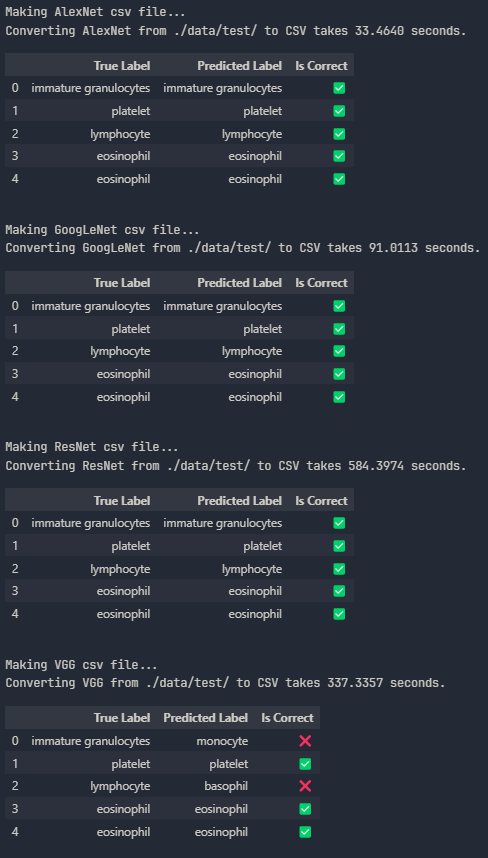

In [31]:
def make_detailed_training_results(IN_COLAB: bool):
    training_results_path = "drive/My Drive/IBDA4311/CNN/training_results/" if IN_COLAB else "./training_results/"
    for results in listdir(training_results_path):
        with open(training_results_path+results, "r", encoding="utf8") as myfile: results_strings = myfile.read()
        results_dict = parse_training_results_string(results_strings)
        path_to_save = f"./detailed_training_results/{results_dict['model_name']}_detailed_training_results.txt"
        file = open(path_to_save, "wb")
        pickle.dump(results_dict, file)
        file.close()

make_detailed_training_results(IN_COLAB)

In [32]:
def evaluate_model(model, dataloader, device, model_name):
    print(f"Evaluating {model_name}...")
    start_time = perf_counter()
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_predictions = np.concatenate(all_predictions)

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='macro') * 100
    recall = recall_score(all_labels, all_predictions, average='macro') * 100
    f1 = f1_score(all_labels, all_predictions, average='macro') * 100

    end_time = perf_counter()
    execution_time = end_time - start_time
    print(f"Evaluation for {model_name} takes {execution_time:.4f} seconds")
    print(f"{model_name} Evaluation finished!\n")

    return all_labels, all_predictions, round(accuracy, 4), round(precision, 4), round(recall, 4), round(f1, 4)

In [33]:
def make_model_evaluation_csv(model_csv_list, model_list, dataloader, device):
    start_time = perf_counter()

    temp = {
        "Model Name": [],
        "#Correct Predictions": [],
        "#Wrong Predictions": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": [],
    }

    all_predictions = {
        "all_labels": None,
        "AlexNetPredictions": None,
        "ResNet152Predictions": None,
        "GoogLeNetPredictions": None,
        "VGG16Predictions": None,
    }

    for model_csv, model_filename in zip(model_csv_list, model_list):
        model_name = model_filename.split("_")[0]
        model = torch.load(f"./models/{model_filename}").to(device)

        df = pd.read_csv(f"./csv/{model_csv}")

        all_labels, predictions, accuracy, precision, recall, f1 = evaluate_model(model, dataloader, device,model_name)
        num_of_correct_prediction = df['Is Correct'].value_counts().get('✅', 0)
        num_of_wrong_prediction = len(df) - num_of_correct_prediction

        temp["Model Name"].append(model_name)
        temp["#Correct Predictions"].append(num_of_correct_prediction)
        temp["#Wrong Predictions"].append(num_of_wrong_prediction)
        temp["Accuracy"].append(accuracy)
        temp["Precision"].append(precision)
        temp["Recall"].append(recall)
        temp["F1 Score"].append(f1)

        all_predictions["all_labels"] = all_labels

        if model_name == "AlexNet": all_predictions["AlexNetPredictions"] = predictions
        elif model_name == "GoogLeNet": all_predictions["GoogLeNetPredictions"] = predictions
        elif model_name == "ResNet": all_predictions["ResNet152Predictions"] = predictions
        elif model_name == "VGG": all_predictions["VGG16Predictions"] = predictions

    df_result = pd.DataFrame(temp).sort_values(by="#Correct Predictions", ascending=False).reset_index(drop=True)
    df_result.to_csv("evaluation/all_model_evaluation.csv", index=False, encoding='utf-8')

    end_time = perf_counter()
    execution_time = end_time - start_time

    print(f"Make Model Evaluation CSV Takes {execution_time:.4f} seconds")
    return all_predictions

# all_csv_models = listdir("./csv/")
# all_models = listdir("./models/")
# temp_dict = make_model_evaluation_csv(all_csv_models, all_models, test_loader, device)

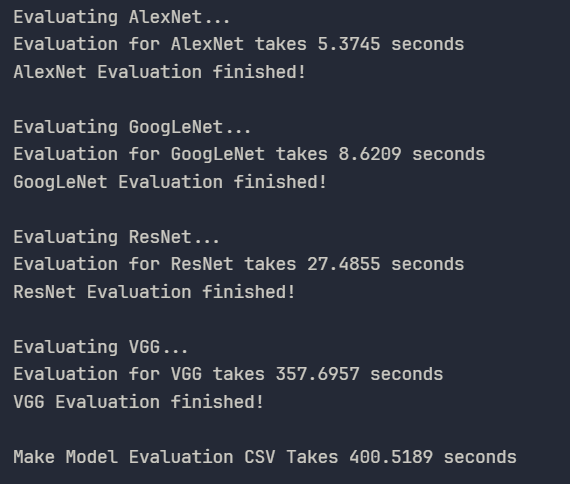

In [34]:
# file = open('./save_variables/temp_dict.txt', 'wb')
# pickle.dump(temp_dict, file)
# file.close()

# Analisa Perbandingan Model

## Plot Training Accuracy and Training Loss

In [35]:
def get_plot_datas(models):
    modelname = models["model_name"]
    epoch_num = list(map(int, models["epochs"]))
    epoch_loss_values = list(map(float, models["epoch_losses"]))
    training_accs = [float(training_acc.strip('%')) / 100 for training_acc in models["training_accs"]]
    return modelname, epoch_num, epoch_loss_values, training_accs

def plot_training_loss_or_training_acc(show_all: bool, path:str, is_training_loss: bool, all_path:str = "./detailed_training_results/"):
    if show_all:
        num_columns = 2
        num_rows = 2
        fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 12))
        if is_training_loss: fig.suptitle("All Models Training Loss", fontsize=16)
        else: fig.suptitle("All Models Training Accuracy", fontsize=16)

        for i, filename in enumerate(listdir(all_path)):
            with open(f'{all_path}{filename}', 'rb') as f: models = pickle.load(f)

            modelname, epoch_num, epoch_loss_values, training_accs = get_plot_datas(models)

            row_index = i // num_columns
            col_index = i % num_columns

            title = modelname + " Training Loss" if is_training_loss else modelname + " Training Accuracy"
            if is_training_loss:
                axs[row_index, col_index].plot(epoch_num, epoch_loss_values, 'o-')
            else:
                axs[row_index, col_index].plot(epoch_num, training_accs, 'o-',color='red')

            axs[row_index, col_index].set_title(title)
            axs[row_index, col_index].set_xlabel('Epochs')

            if is_training_loss: axs[row_index, col_index].set_ylabel('Loss')
            else: axs[row_index, col_index].set_ylabel('Accuracy')

            for epoch, loss_value, acc in zip(epoch_num, epoch_loss_values, training_accs):
                if is_training_loss:
                    loss_value = float(loss_value)
                    axs[row_index, col_index].annotate(f'{loss_value:.3f}', (int(epoch) + 0.3, loss_value), textcoords="offset points", xytext=(0, 5), ha='center')
                else:
                    axs[row_index, col_index].annotate(f'{acc:.3f}', (int(epoch) + 0.3, acc),textcoords="offset points", xytext=(0, 5), ha='center')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if is_training_loss: plt.savefig("plots/training_loss/all_models_training_loss.jpg")
        else: plt.savefig("plots/training_accuracy/all_models_training_accuracy.jpg")

    else:
        plt.figure(figsize=(20,5))
        with open(path, 'rb') as f: models = pickle.load(f)

        modelname, epoch_num, epoch_loss_values, training_accs = get_plot_datas(models)
        if is_training_loss:
            plt.plot(epoch_num, epoch_loss_values, 'o-', label='Training Loss')
            plt.ylabel('Loss')
        else:
            plt.plot(epoch_num, training_accs, 'o-', label='Training Accuracy', color='red')
            plt.ylabel('Accuracy')

        title = modelname + " Training Loss" if is_training_loss else modelname + " Training Accuracy"
        plt.title(title)
        plt.xlabel('Epochs')

        for epoch, loss_value, acc in zip(epoch_num, epoch_loss_values, training_accs):
            if is_training_loss:
                loss_value = float(loss_value)
                plt.annotate(f'{loss_value:.3f}', (int(epoch) + 0.3, loss_value), textcoords="offset points", xytext=(0, 5), ha='center')
            else:
                plt.annotate(f'{acc:.3f}', (int(epoch) + 0.3, acc),textcoords="offset points", xytext=(0, 5), ha='center')

        if is_training_loss: plt.savefig(f"plots/training_loss/{modelname}_training_loss_plot.jpg")
        else: plt.savefig(f"plots/training_accuracy/{modelname}_training_accuracy_plot.jpg")

    plt.show()

def plot_all_training_loss_or_acc_vertically(is_training_loss:bool, all_path:str = "./detailed_training_results/"):
    for filename in listdir(all_path):
        path = f"{all_path}{filename}"
        plot_training_loss_or_training_acc(False, path, is_training_loss)

### Plot Training Loss

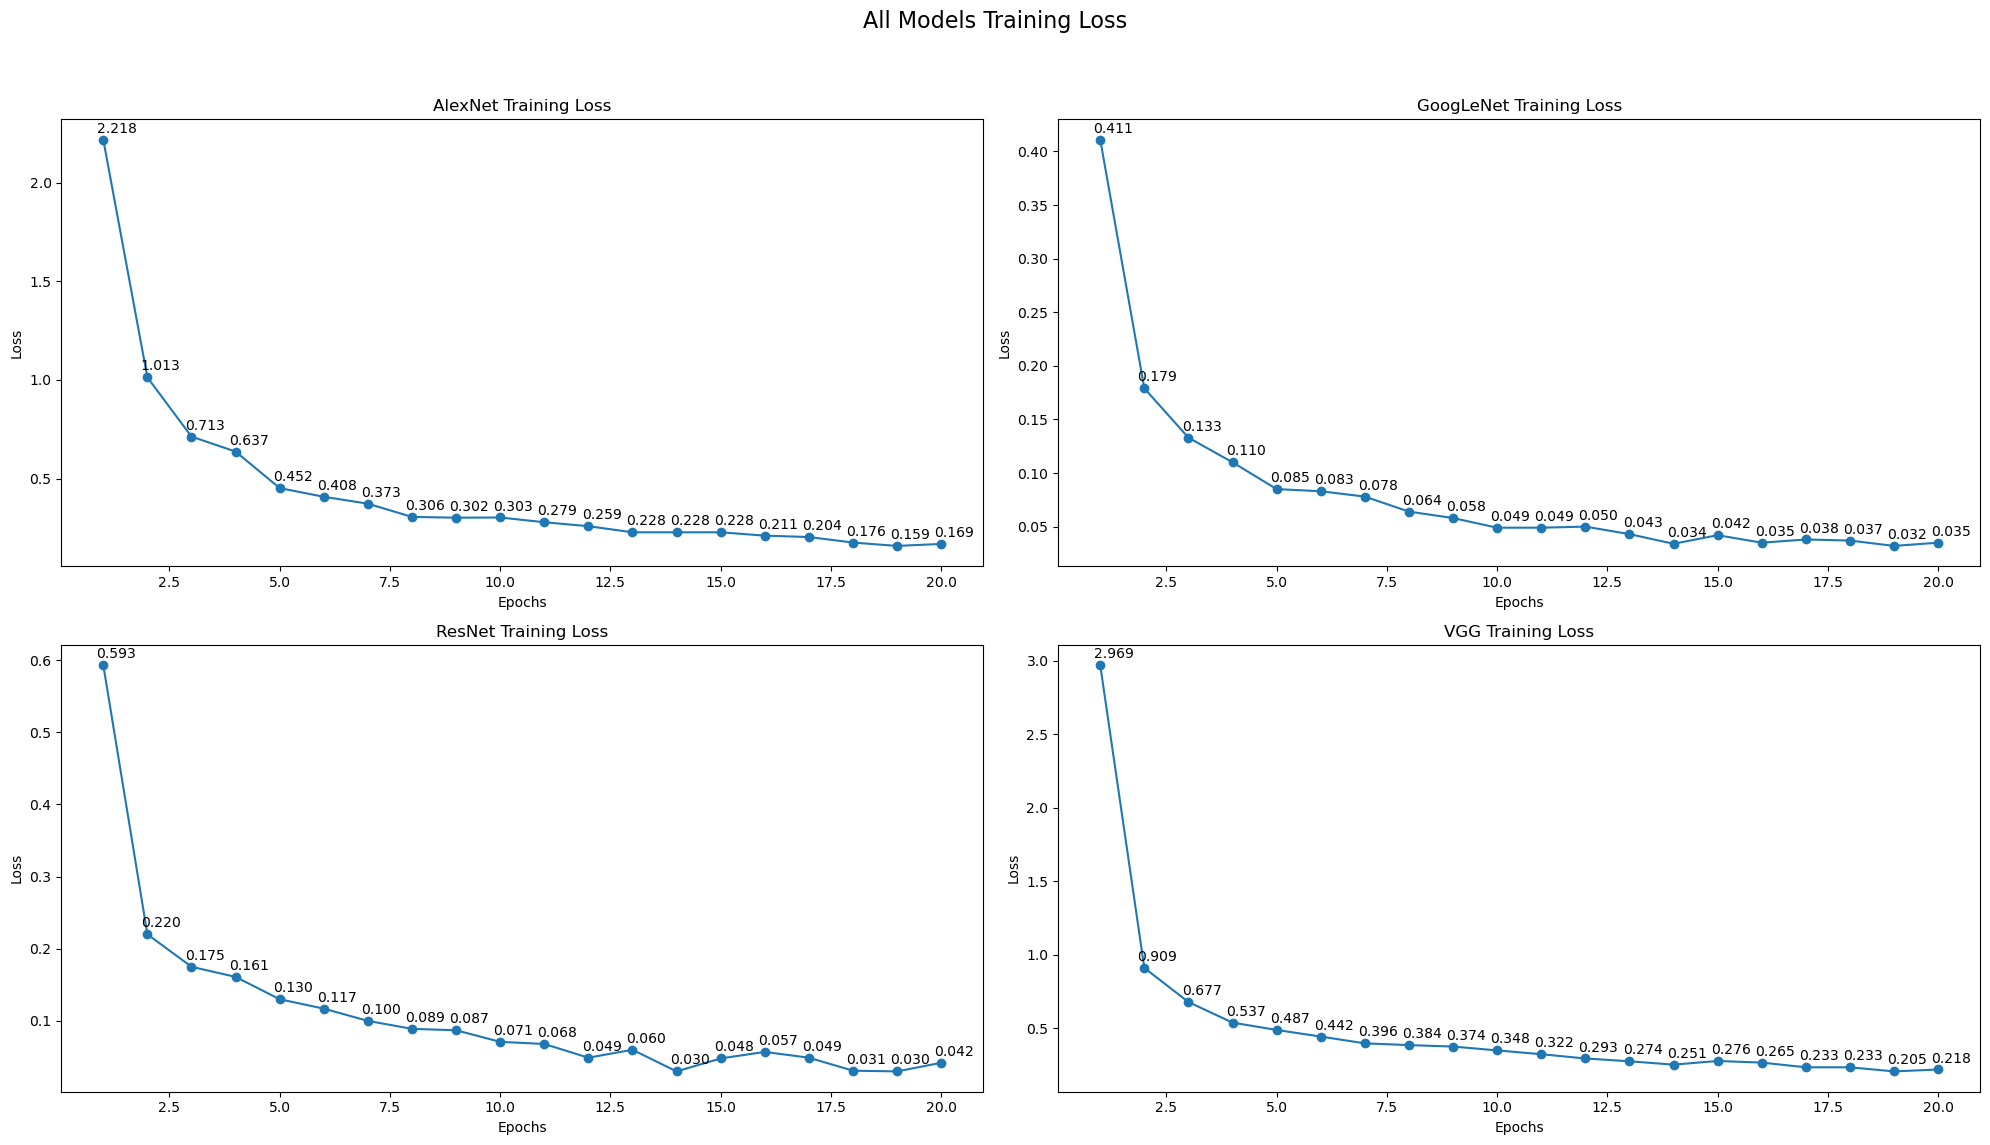

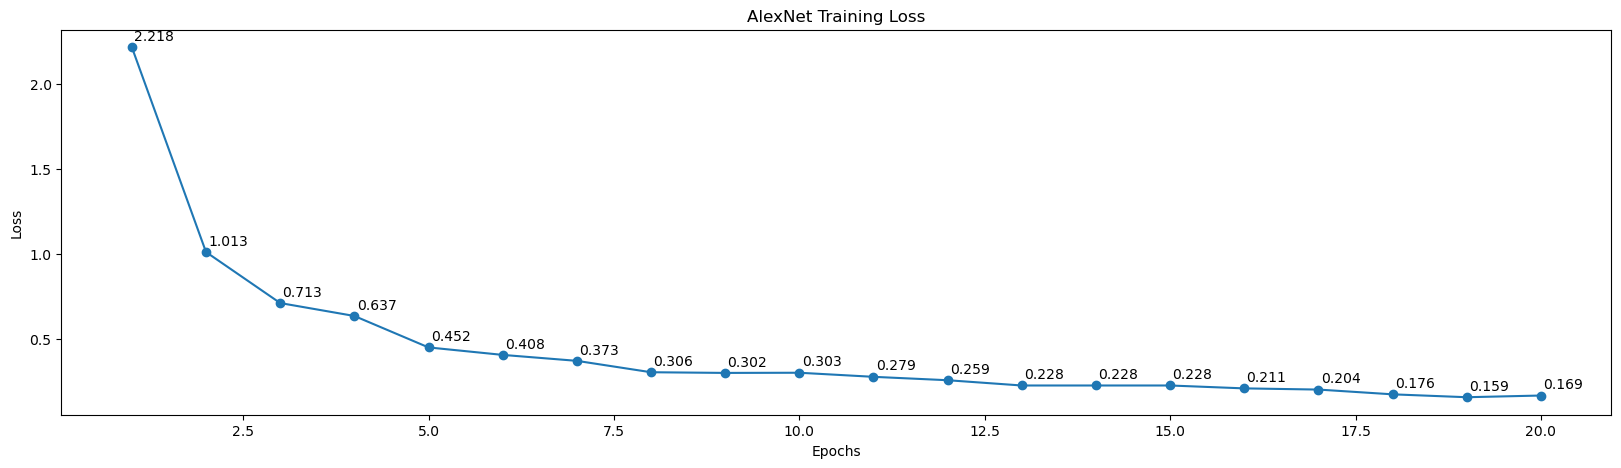

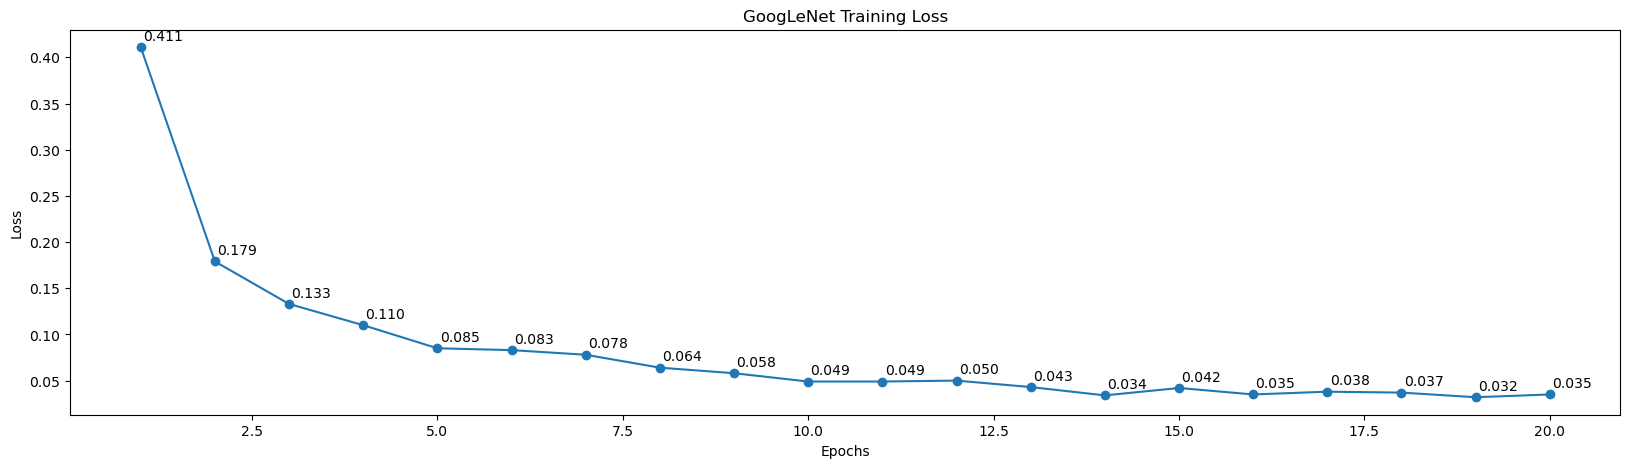

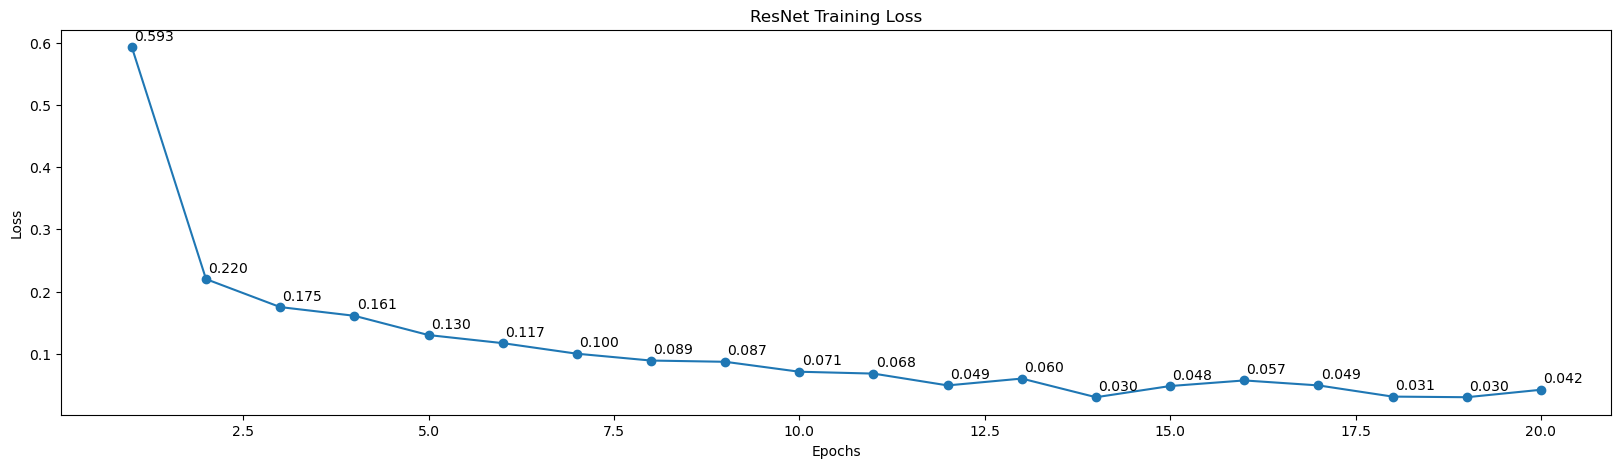

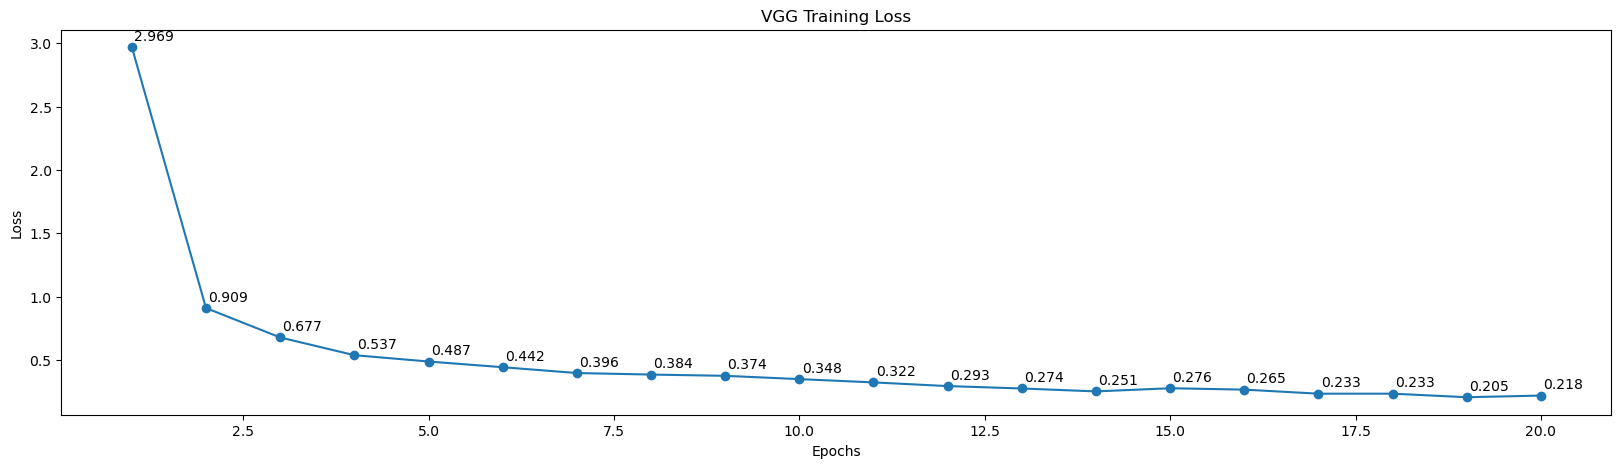

In [36]:
plot_training_loss_or_training_acc(True,"",True)
plot_all_training_loss_or_acc_vertically(True)

### Plot Training Accuracy

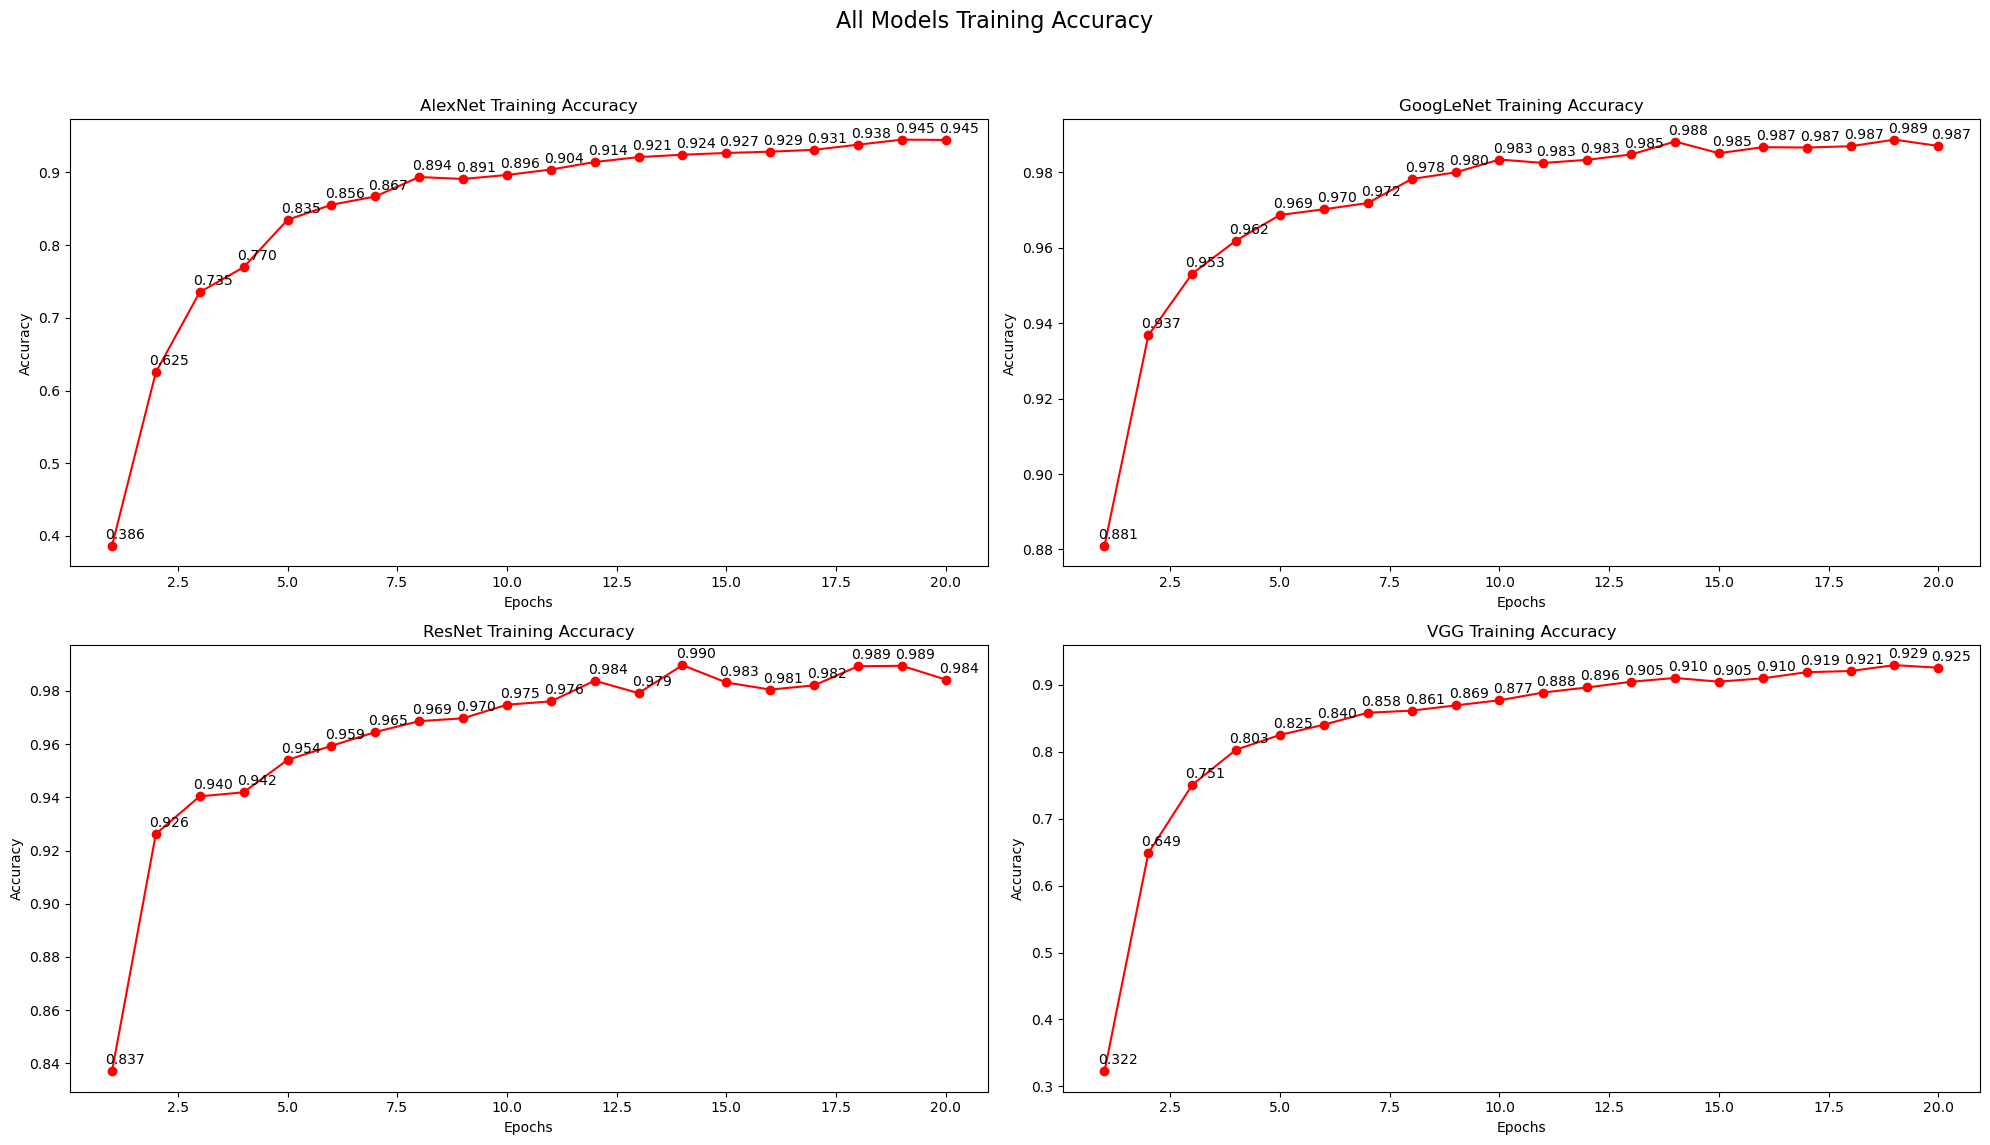

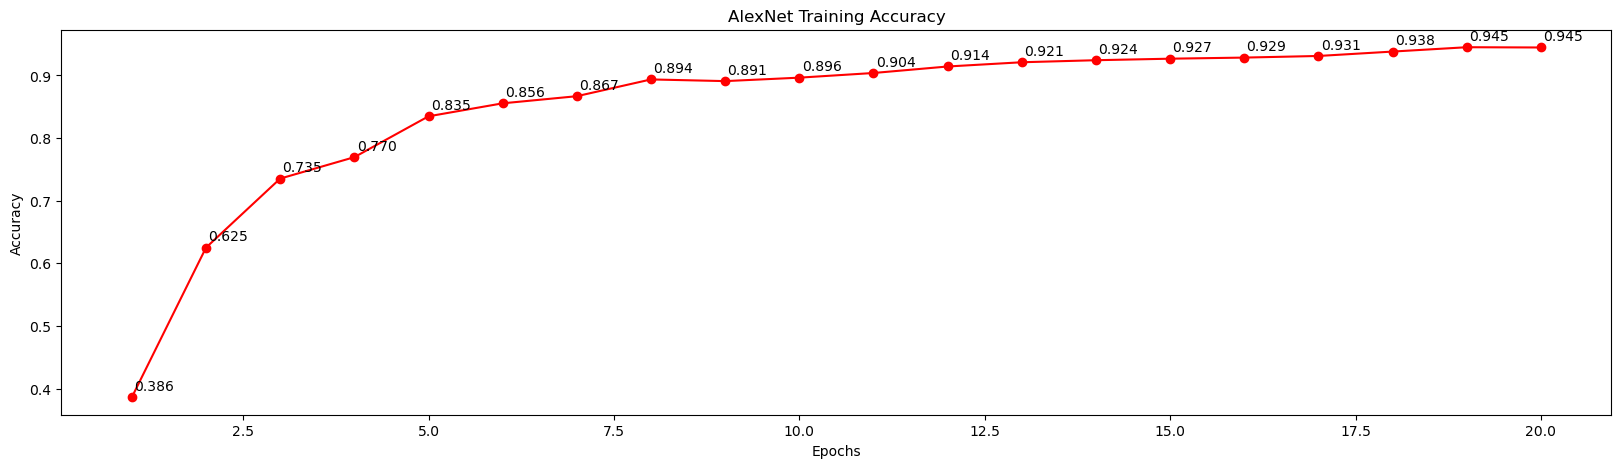

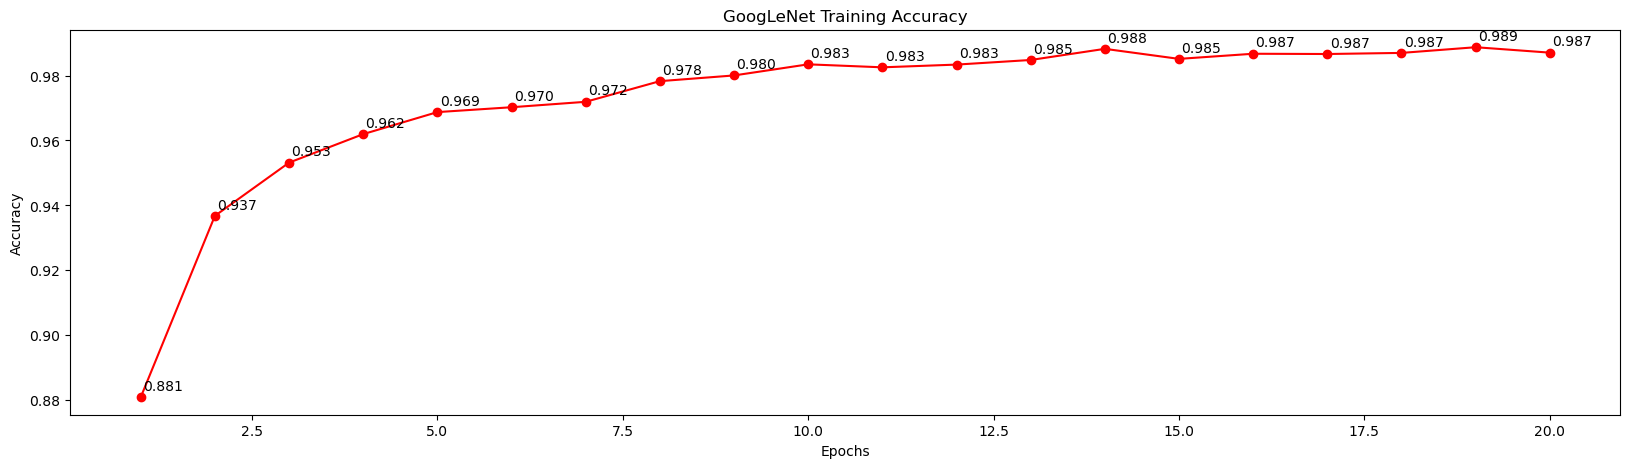

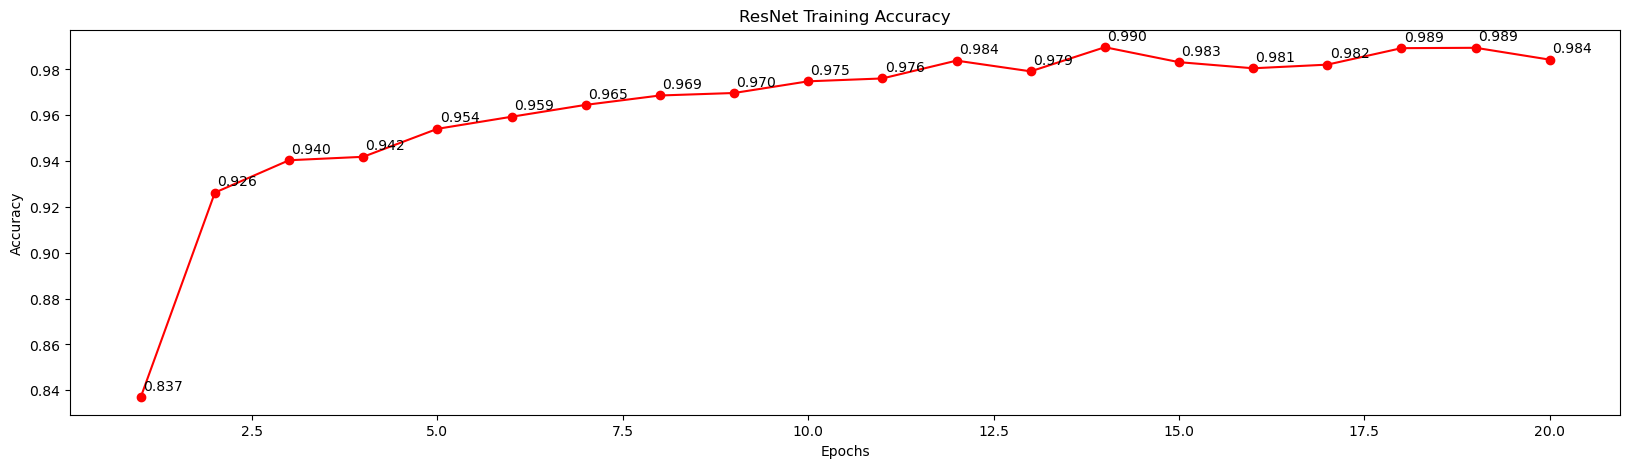

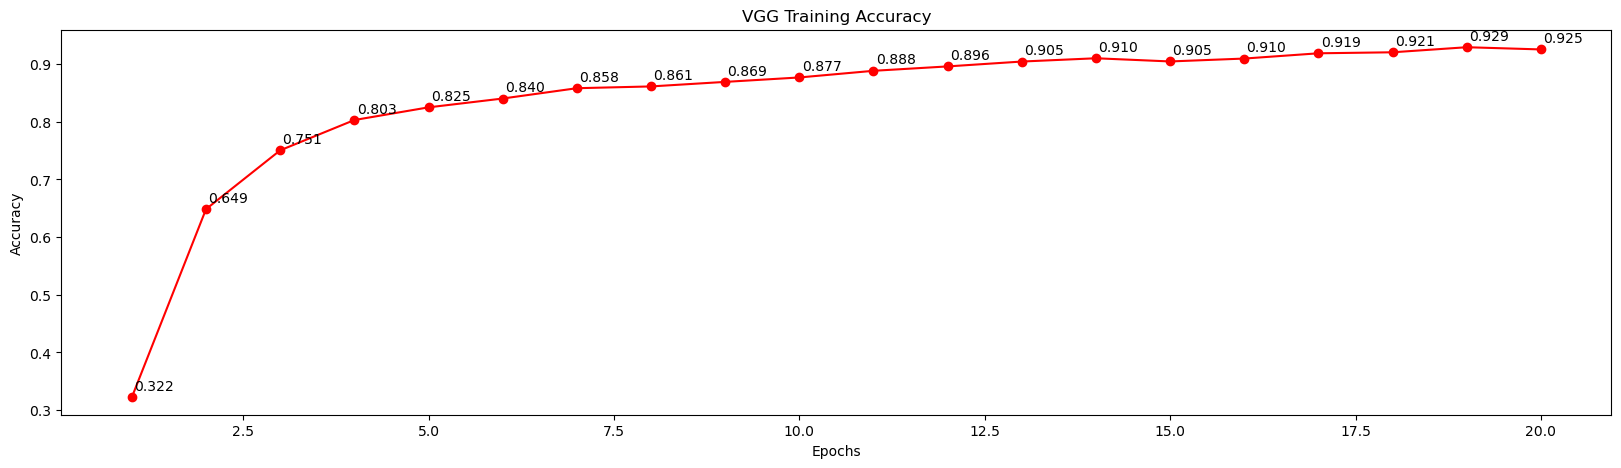

In [37]:
plot_training_loss_or_training_acc(True,"",False)
plot_all_training_loss_or_acc_vertically(False)

In [38]:
model_evaluation_df = pd.read_csv("./evaluation/all_model_evaluation.csv")

def convert_to_hours_minutes_seconds_format(seconds: float):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return f"{int(hour)} hours, {int(minutes)} minutes, {int(seconds)} seconds"

def add_model_evaluation_df_columns(all_path: str = "./detailed_training_results/"):
    best_epochs = {}
    total_times = {}
    lowest_training_losses = {}

    for filename in listdir(all_path):
        with open(f'{all_path}{filename}', 'rb') as f: models = pickle.load(f)
        model_name = models['model_name']

        lowest_training_loss = min(list(map(float, models["epoch_losses"])))
        best_epoch = models["best_epoch"]
        total_time = convert_to_hours_minutes_seconds_format(float(models['total_time'].split("seconds")[0]))

        lowest_training_losses[model_name] = lowest_training_loss
        best_epochs[model_name] = best_epoch
        total_times[model_name] = total_time

    model_evaluation_df['Lowest Training Loss'] = model_evaluation_df['Model Name'].map(lowest_training_losses)
    model_evaluation_df['Best Epoch'] = model_evaluation_df['Model Name'].map(best_epochs)
    model_evaluation_df['Training Time'] = model_evaluation_df['Model Name'].map(total_times)

add_model_evaluation_df_columns()
display(model_evaluation_df)

,Model Name,#Correct Predictions,#Wrong Predictions,Accuracy,Precision,Recall,F1 Score,Lowest Training Loss,Best Epoch,Training Time
0,ResNet,3278,143,95.8199,95.6497,95.1799,95.3404,0.030,18,"19 hours, 14 minutes, 11 seconds"
1,GoogLeNet,3271,150,95.6153,94.7455,95.1773,94.8394,0.032,17,"1 hours, 51 minutes, 35 seconds"
2,AlexNet,3162,259,92.4291,91.3817,91.2583,91.1861,0.159,16,"0 hours, 13 minutes, 44 seconds"
3,VGG,3134,287,91.5814,90.7046,90.0089,90.3149,0.205,20,"11 hours, 31 minutes, 40 seconds"


## Confusion Matrix

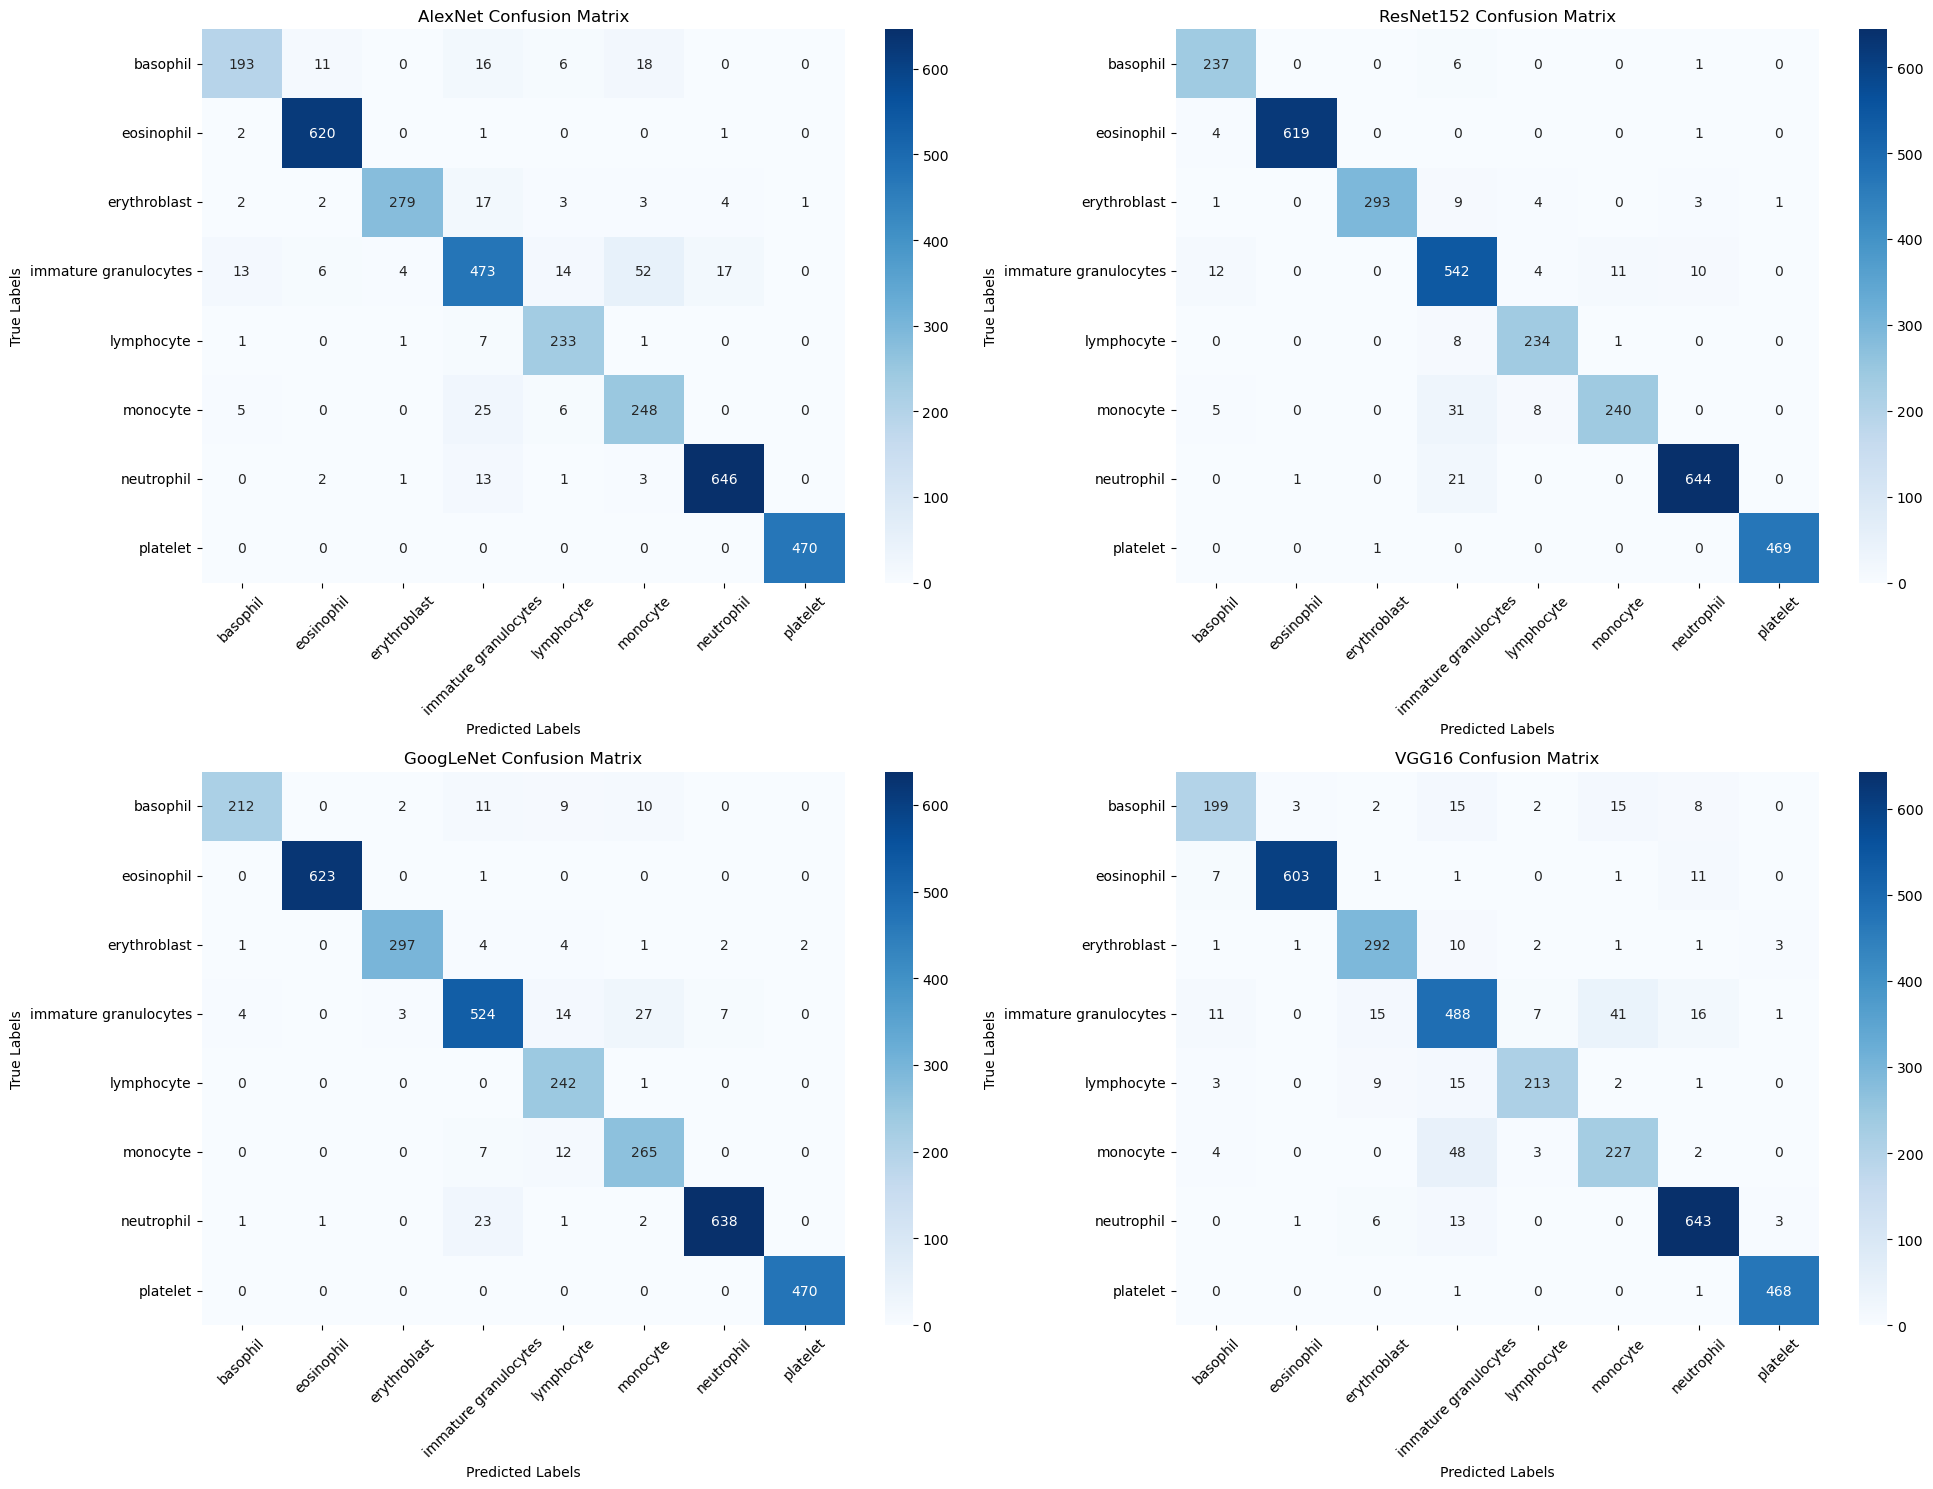

<Figure size 2000x1500 with 0 Axes>

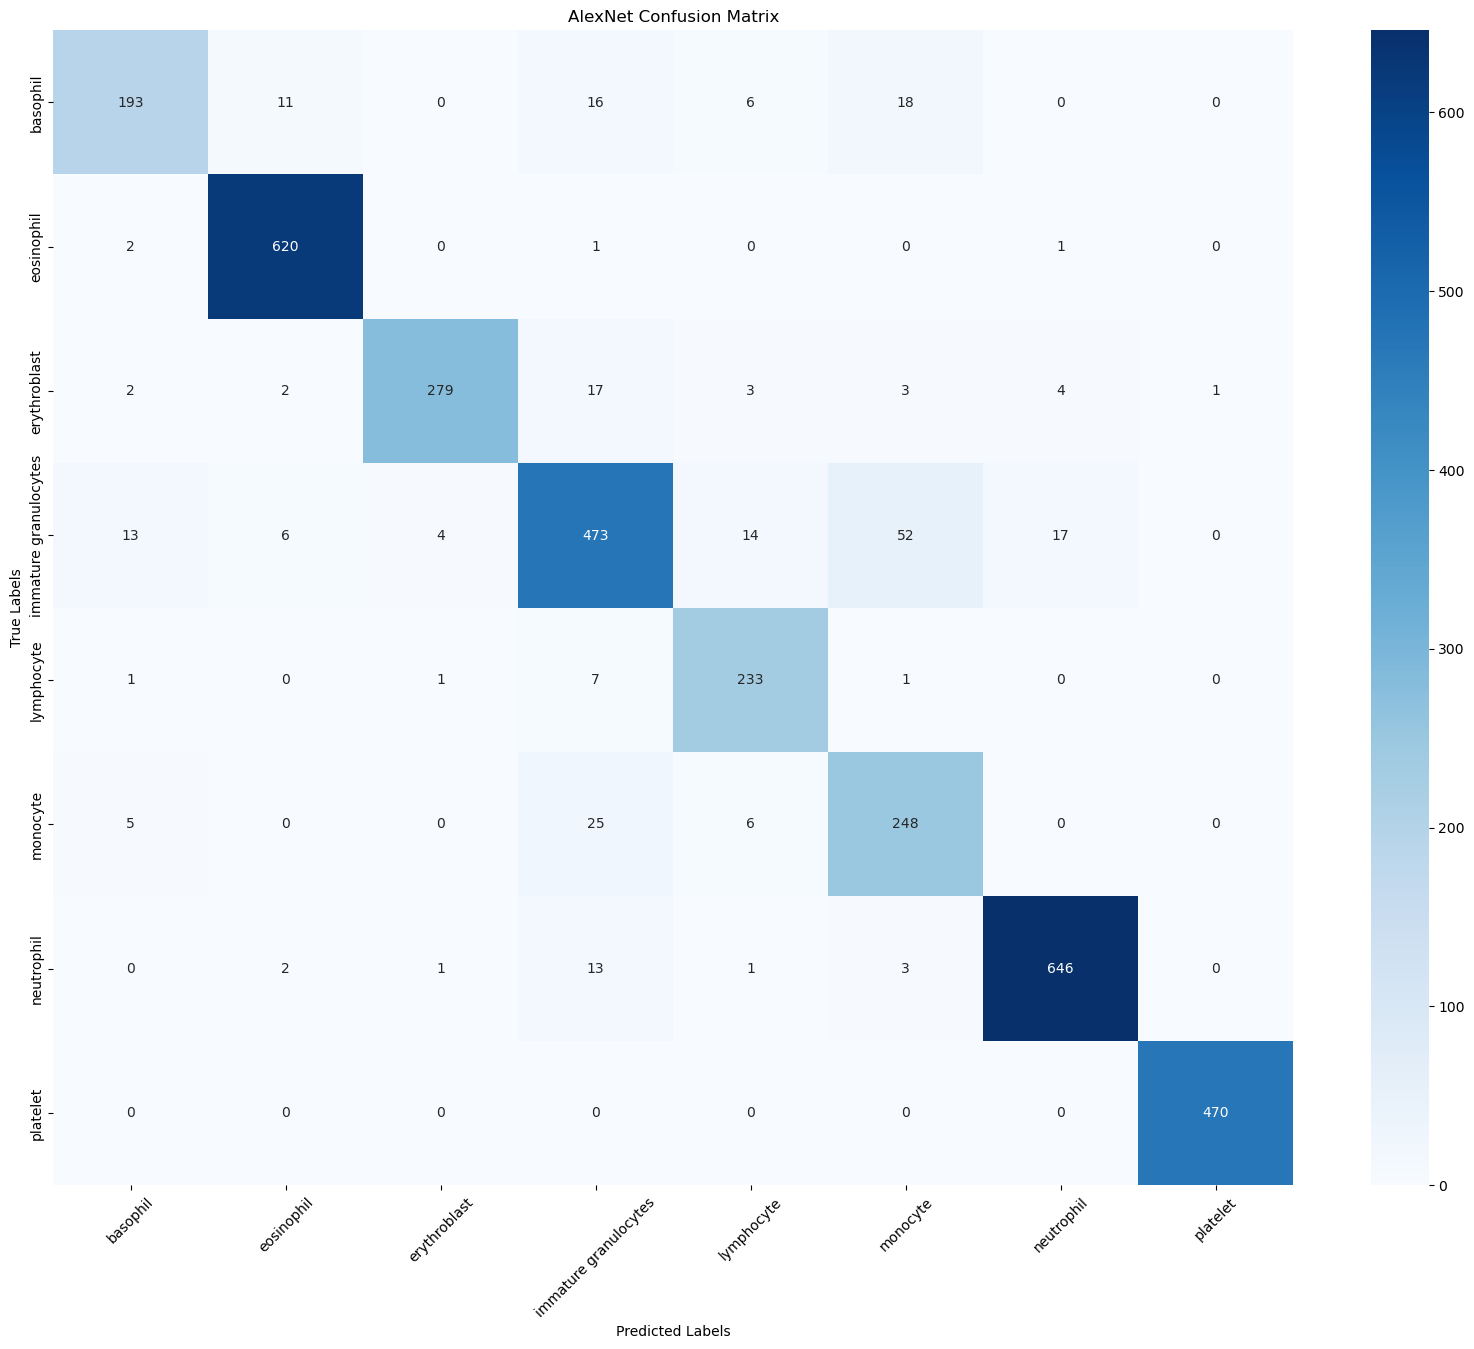

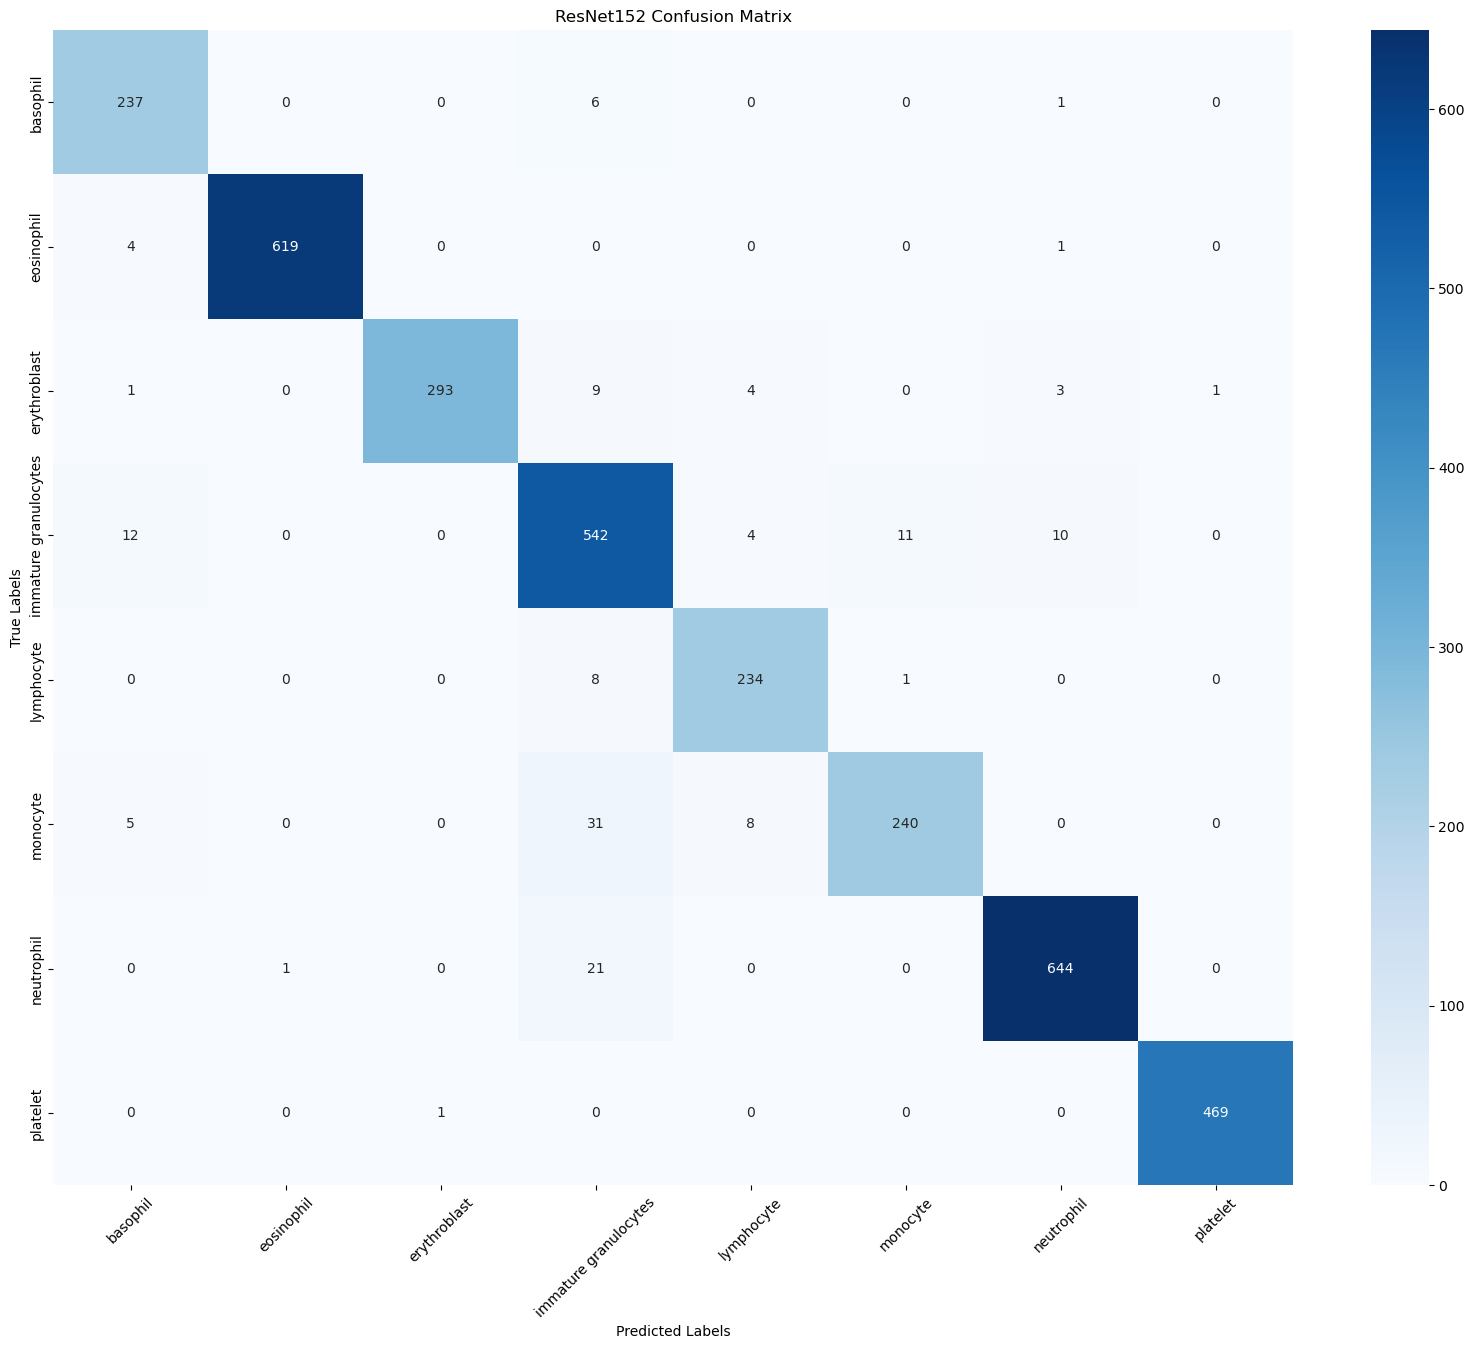

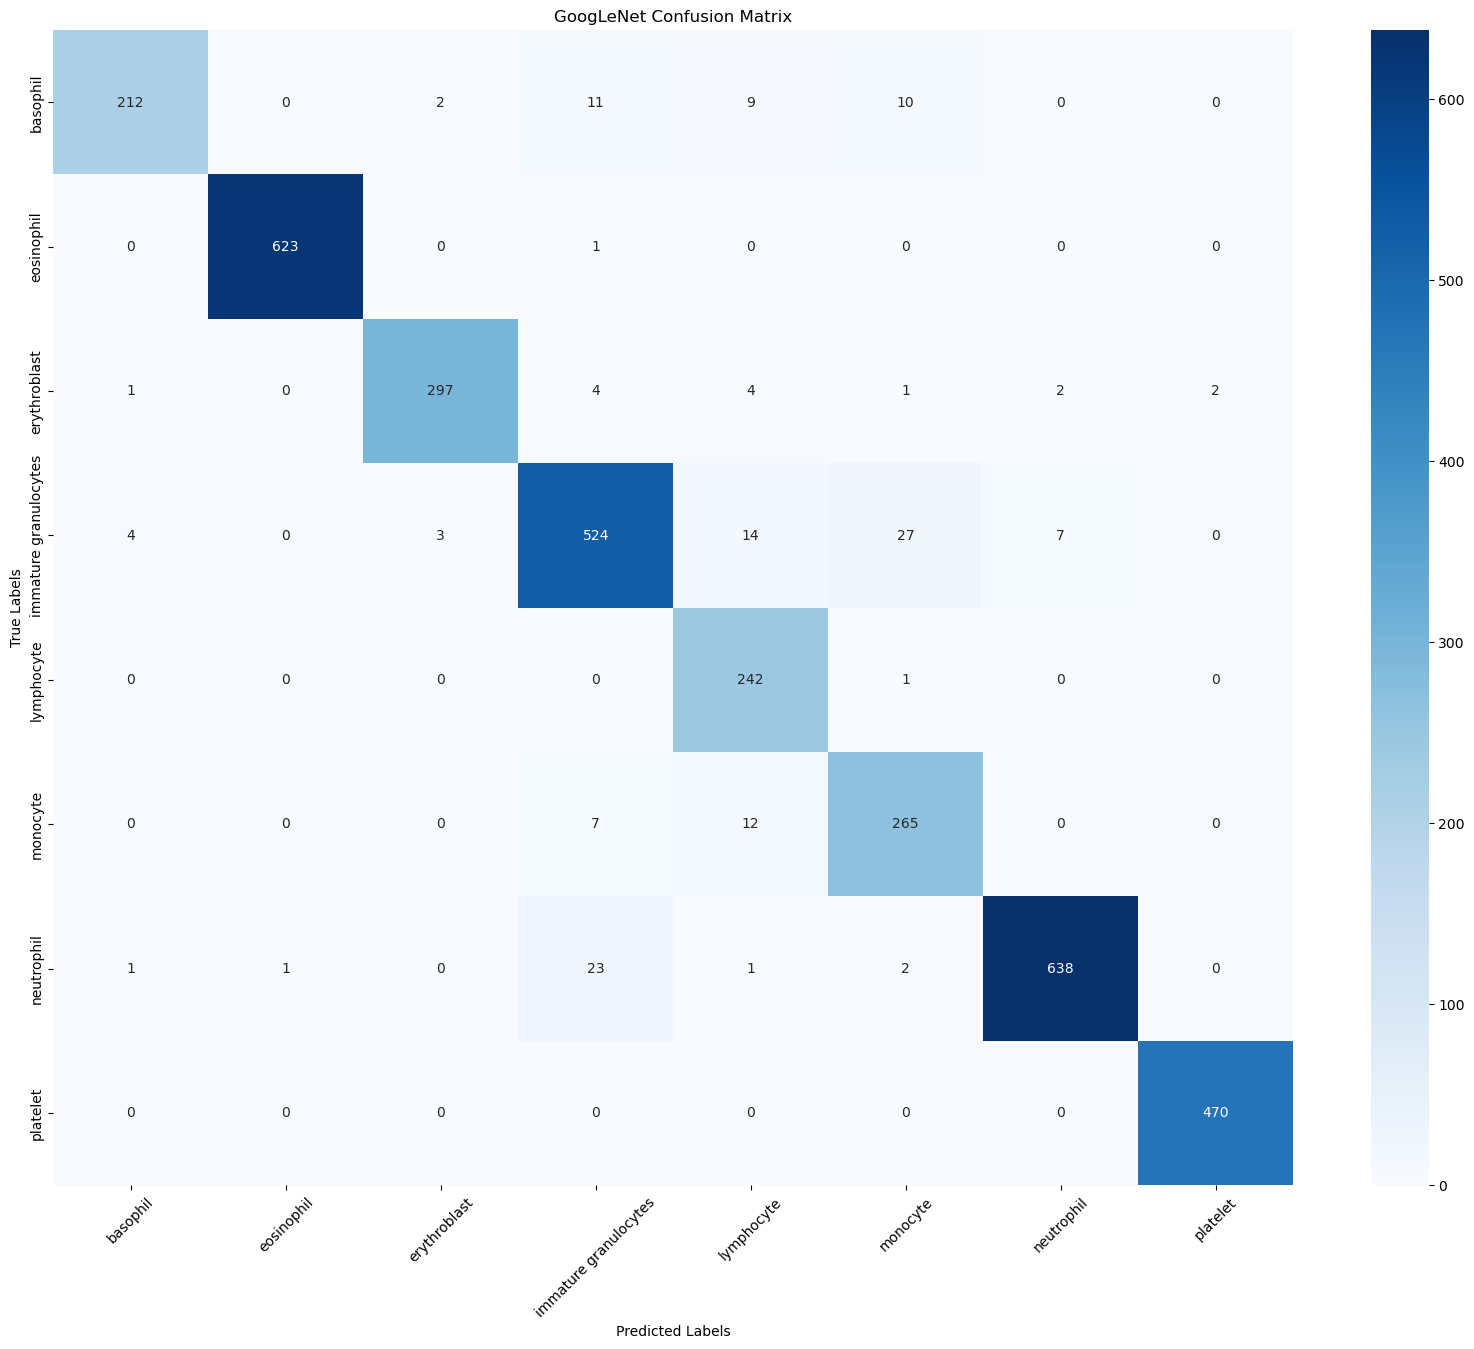

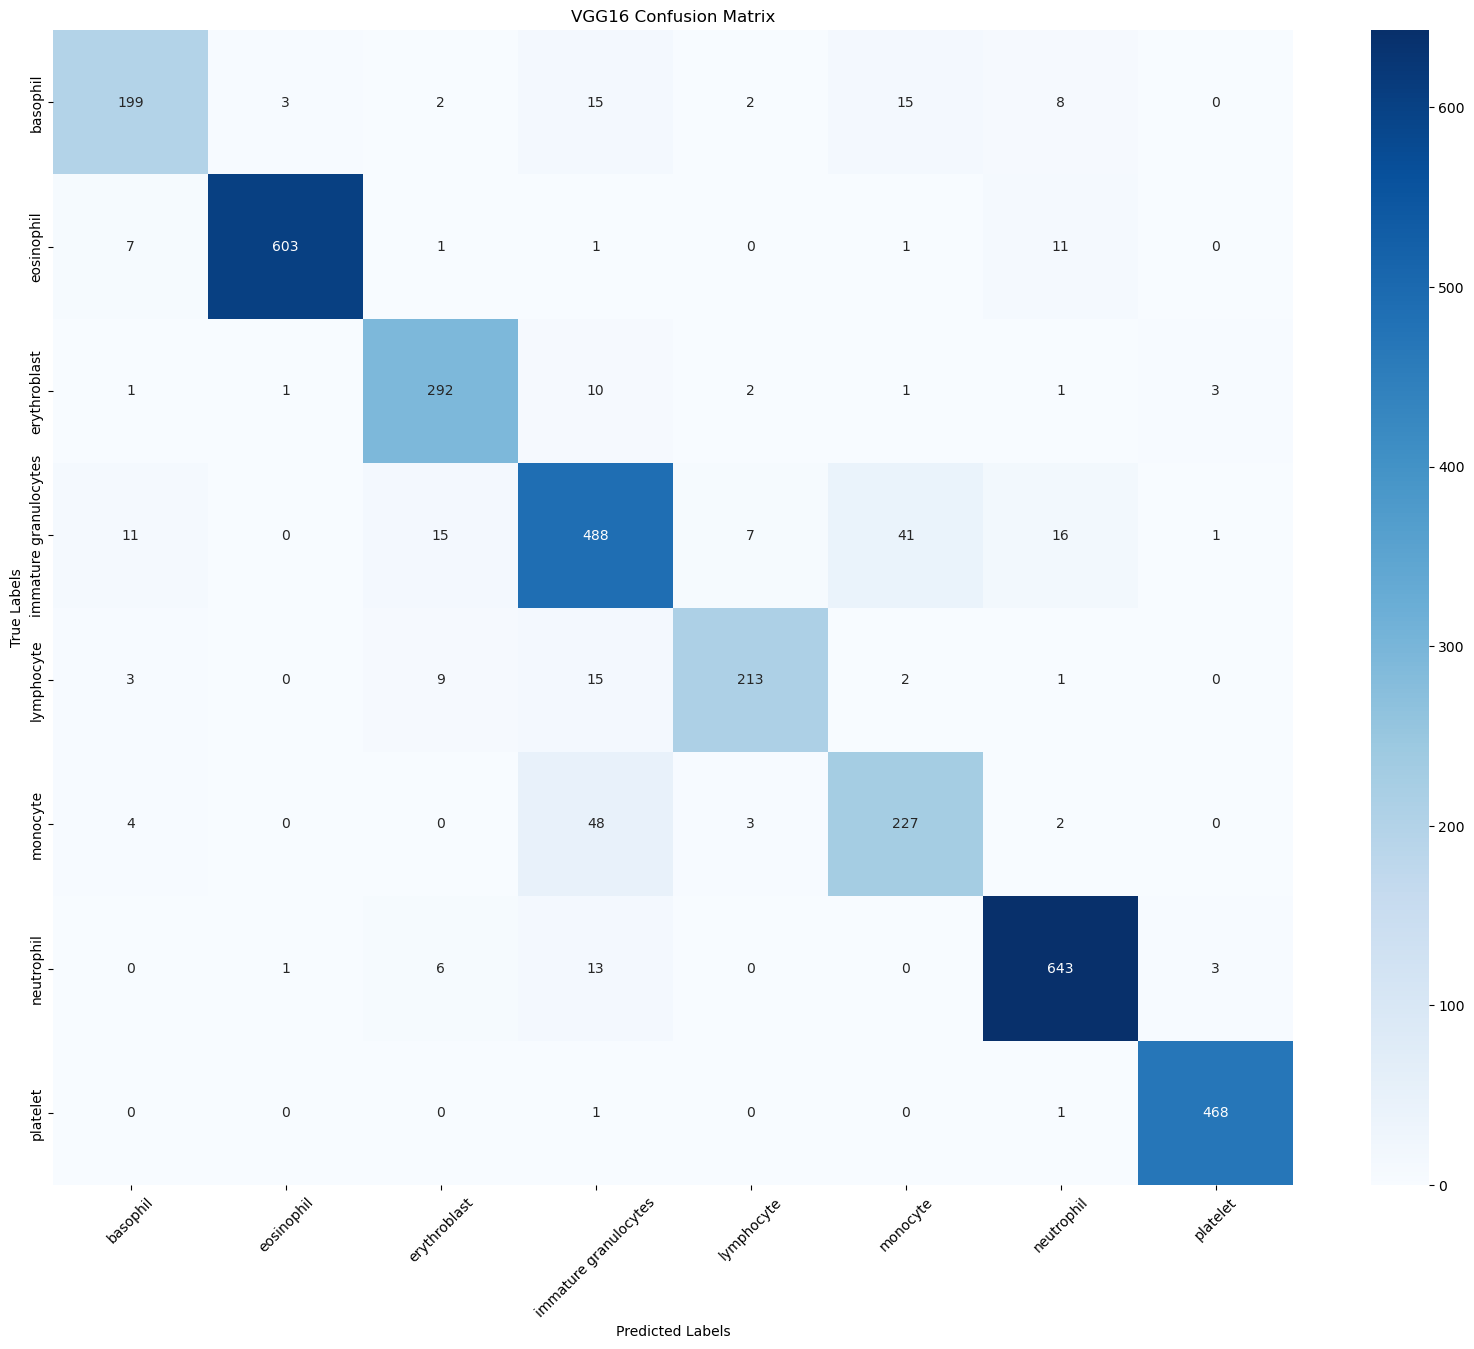

<Figure size 640x480 with 0 Axes>

In [39]:
def make_confusion_matrix_subplot(all_labels, all_predictions, class_names: list[str], model_name, subplot_position):
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    plt.subplot(2, 2, subplot_position)
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.xticks(rotation=45)
    plt.ylabel('True Labels')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.savefig("confusion_matrix/all_models_confusion_matrix.jpg")

def make_single_confusion_matrix(all_labels, all_predictions, class_names: list[str], model_name):
    plt.figure(figsize=(20, 15))
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.xticks(rotation=45)
    plt.ylabel('True Labels')
    plt.savefig(f"confusion_matrix/{model_name}_confusion_matrix.jpg")
    plt.show()

def plot_confusion_matrices(show_all:bool, temp_dict, classes):
    all_labels = temp_dict["all_labels"]

    plt.figure(figsize=(20, 15))

    model_names = ["AlexNet", "ResNet152", "GoogLeNet", "VGG16"]
    for i, key in enumerate(["AlexNetPredictions", "ResNet152Predictions", "GoogLeNetPredictions", "VGG16Predictions"], 1):
        all_predictions = temp_dict[key]
        model_name = model_names[i - 1]
        if show_all: make_confusion_matrix_subplot(all_labels, all_predictions, classes, model_name, i)
        else: make_single_confusion_matrix(all_labels, all_predictions, classes, model_name)

    plt.tight_layout()
    plt.show()

with open('./save_variables/temp_dict.txt', 'rb') as f: temp_dict = pickle.load(f)
plot_confusion_matrices(True, temp_dict, classes)
plot_confusion_matrices(False, temp_dict, classes)

## Analisa Keseluruhan

### AlexNet

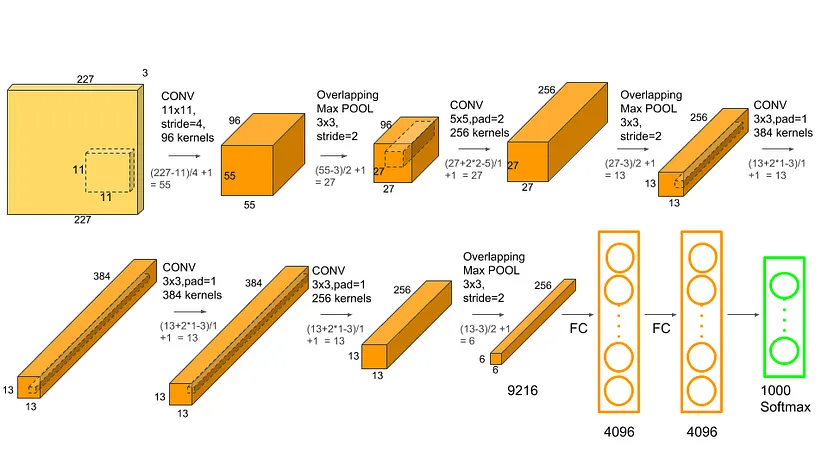

<style>
	div {
		text-align: justify
	}

    table {
        width: 100%;
        border-collapse: collapse;
        margin-bottom: 20px;
    }

    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }

    th {
        background-color: #f2f2f2;
    }

    h2, h3, h4, h5, h6 {
        font-weight: bold;
    }

    ul, ol {
        margin-top: 0;
    }

    img {
        max-width: 100%;
        height: auto;
        margin-bottom: 20px;
    }
</style>

<div>
	<h2> Kelebihan AlexNet</h2>
      <ul>
        <li>Membuka jalan bagi perkembangan arsitektur CNN modern.</li>
        <li>Memperkenalkan teknik dropout untuk mengatasi overfitting.</li>
        <li>Relatif sederhana dan mudah diimplementasikan.</li>
      </ul>
	<h2>Kekurangan AlexNet</h2>
     <ul>
        <li>Tidak seefisien model-model terkini dalam hal representasi fitur.</li>
        <li>Kinerja mungkin tidak sebaik model-model lebih baru.</li>
      </ul>
	<h2> Grafik Training Loss </h2>
	<img src="plots\training_loss\AlexNet_training_loss_plot.jpg" alt="AlexNet Training Loss">
	<h3>Analisa Grafik Training Loss</h3>
	<ol>
		<li><b>Penurunan Loss:</b> Grafik menunjukkan penurunan loss yang stabil selama 20 epoch. Loss awal model AlexNet adalah 2.218 dan menurun hingga 0.169 di akhir epoch ke-20. Ini menunjukkan model belajar dengan baik dan mampu meningkatkan akurasinya dalam mengklasifikasikan data BloodMNIST.
		</li>
		<br>
		<li><b>Penurunan Loss Cepat di Awal: </b>Penurunan loss paling signifikan terjadi di epoch awal (sampai epoch ke-5) dan mulai stabil di epoch 5-10. Setelah epoch 10, kurva loss masih menunjukkan tren menurun, tapi dengan tingkat yang lebih lambat.
		</li>
	</ol>
	<h2>Grafik Akurasi Training</h2>
	<img src="plots\training_accuracy\AlexNet_training_accuracy_plot.jpg" alt="AlexNet Training Accuracy">
	<h3>Analisa Grafik Akurasi Training</h3>
	<ol>
		<li><b>Upward trend:</b> Grafik menunjukkan tren naik yang stabil selama 20 epoch. Akurasi awal model AlexNet adalah 0.386 dan meningkat hingga 0.945 di akhir epoch ke-20. Ini menunjukkan model belajar dengan baik dan mampu meningkatkan akurasi prediksinya dalam mengklasifikasikan data BloodMNIST.
		</li>
		<br>
		<li><b>Smoothness: </b>Grafik cukup halus, tanpa fluktuasi yang signifikan. Fluktuasi kecil dapat terjadi, namun tidak terlalu mengganggu. Ini menunjukkan model stabil dan tidak overfitting ke data training.
		</li>
		<br>
		<li><b>Plateaus: </b>Grafik tidak mencapai plateau di akhir epoch ke-20. Ini menunjukkan model masih memiliki ruang untuk meningkatkan akurasi.
		</li>
	</ol>
	<h2>Confusion Matrix</h2>
	<img src="confusion_matrix\AlexNet_confusion_matrix.jpg"  alt="AlexNet Confusion Matrix">
	<h3>Analisa Confusion Matrix</h3>
	<ul>
		<li>Model Alexnet paling banyak gagal memprediksi immature granulocytes. Dapat dilihat bahwa terdapat 52 immature granulocytes yang diprediksi sebagai monocyte dan terdapat 25 monocyte yang diprediksi sebagai immature granulocytes.</li>
	</ul>
	<h2>Tabel Akurasi, Precision, Recall, F1, Best Epoch, Lowest Loss, Training Time</h2>
	<table>
	    <thead>
	        <tr>
	            <th>Test Data Accuracy Score</th>
	            <th>Test Data Precision Score</th>
	            <th>Test Data Recall Score</th>
	            <th>Test Data F1 Score</th>
	            <th>Test Data Best Epoch</th>
	            <th>Training Data Lowest Loss</th>
	            <th>Total Training Time</th>
	        </tr>
	    </thead>
	    <tbody>
	      <tr>
	          <td>92.4291%</td>
	          <td>91.3817%</td>
	          <td>91.3817%</td>
	          <td>91.1861%</td>
	          <td>16</td>
	          <td>0.159</td>
	          <td>0 hours, 13 minutes, 44 seconds</td>
	      </tr>
		</tbody>
	</table>
	<h3>Analisa Tabel</h3>
	<ol>
	  <li><b>Test Data Accuracy Score (92.4291%):</b><br>
	    Akurasi mengukur sejauh mana model mampu mengenali data uji dengan benar. Nilai 92.4291% menunjukkan bahwa model AlexNet dapat mengklasifikasikan sekitar 92.43% data uji dengan benar.
	  </li>
	  <br>
	  <li><b>Test Data Precision Score (91.3817%):</b><br>
	    Presisi mengukur seberapa banyak dari instance yang diklasifikasikan sebagai positif oleh model yang benar-benar positif. Angka 91.3817% menunjukkan bahwa dari semua instance yang diklasifikasikan sebagai positif, sekitar 91.38% benar-benar positif.
	  </li>
	  <br>
	  <li><b>Test Data Recall Score (91.3817%):</b><br>
	    Recall (sensitivitas) mengukur sejauh mana model dapat mengidentifikasi semua instance positif. Persentase 91.3817% menunjukkan bahwa model dapat mengenali sekitar 91.38% dari semua instance positif yang sebenarnya.
	  </li>
	  <br>
	  <li><b>Test Data F1 Score (91.1861%):</b><br>
	    Skor F1 adalah harmonic mean dari presisi dan recall. Nilai 91.1861% mencerminkan seimbang antara presisi dan recall untuk model AlexNet.
	  </li>
	  <br>
	  <li><b>Test Data Best Epoch (16):</b><br>
	    Best Epoch menunjukkan jumlah epoch ketika model mencapai kinerja terbaik pada data uji. Pada epoch ke-16, model mencapai performa terbaik.
	  </li>
	  <br>
	  <li><b>Training Data Lowest Loss (0.159):</b><br>
	    Ini adalah nilai loss terendah yang diperoleh selama pelatihan model. Loss mengukur seberapa baik model melakukan prediksi terhadap nilai sebenarnya.
	  </li>
	  <br>
	  <li><b>Total Training Time (0 hours, 13 minutes, 44 seconds):</b><br>
	    Menyajikan waktu total yang dibutuhkan untuk melatih model AlexNet. Waktu ini mencakup seluruh proses pelatihan dari awal hingga akhir.
		AlexNet merupakan model yang memiliki <b>waktu training tercepat</b> diantara 3 model lainnya.
	  </li>
	</ol>
</div>

### VGG16

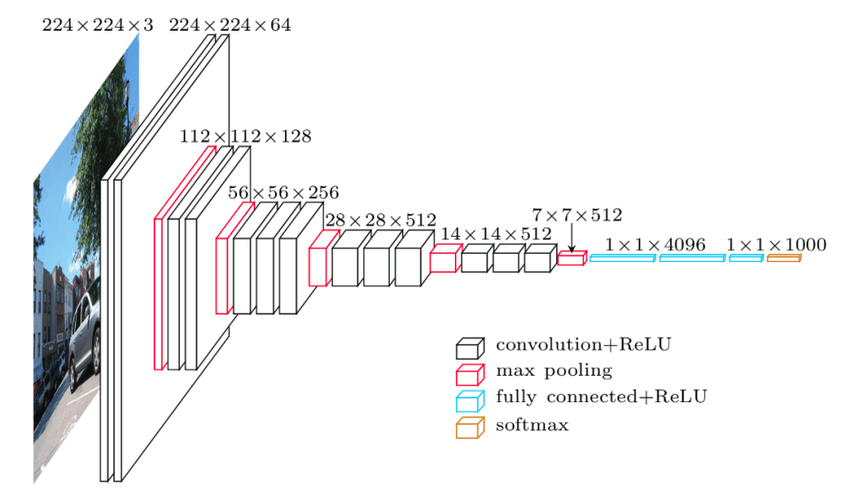    


<style>
	div {
		text-align: justify
	}

  table {
      width: 100%;
      border-collapse: collapse;
      margin-bottom: 20px;
  }

  th, td {
      border: 1px solid #ddd;
      padding: 8px;
      text-align: left;
  }

  th {
      background-color: #f2f2f2;
  }

  h2, h3, h4, h5, h6 {
      font-weight: bold;
  }

  ul, ol {
      margin-top: 0;
  }

  img {
      max-width: 100%;
      height: auto;
      margin-bottom: 20px;
    }
</style>

<div>
  <h2> Kelebihan VGG16</h2>
     <ul>
        <li>Mudah diimplementasikan dan diinterpretasikan.</li>
        <li>Memiliki arsitektur yang simetris dan mendalam.</li>
        <li>Umumnya memberikan hasil yang baik pada tugas klasifikasi gambar.</li>
      </ul>

  <h2>Kekurangan VGG16</h2>
     <ul>
        <li>Memerlukan sumber daya komputasi yang signifikan.</li>
        <li>Mudah mengalami overfitting terutama pada dataset kecil.</li>
      </ul>
  <h2> Grafik Training Loss </h2>
  <img src="plots\training_loss\VGG_training_loss_plot.jpg" alt="VGG16 Training Loss">

  <h3>Analisa Grafik Training Loss</h3>
  <ol>
    <li><b>Tren penurunan loss yang stabil:</b><br>
      Grafik loss VGG16 memiliki tren penurunan yang stabil selama 20 epoch. Hal ini menunjukkan bahwa model VGG16 belajar dengan baik dan mampu mengurangi error-nya dari waktu ke waktu.
    </li>
    <br>
    <li><b>Loss awal yang tinggi:</b><br>
      Loss awal VGG16 sangat tinggi, yaitu sekitar 2.969. Hal ini menunjukkan bahwa model VGG16 kesulitan untuk mengklasifikasikan data BloodMNIST pada awalnya.
    </li>
    <br>
    <li><b>Penurunan loss yang cepat di awal pelatihan:</b><br>
      Penurunan loss VGG16 paling signifikan terjadi di awal pelatihan (sampai epoch ke-5). Hal ini menunjukkan bahwa VGG16 mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Penurunan loss yang lebih lambat di akhir pelatihan:</b><br>
      Penurunan loss VGG16 menjadi lebih lambat di akhir pelatihan (epoch ke-5 hingga epoch ke-20). Hal ini menunjukkan bahwa VGG16 semakin sulit untuk mengurangi error-nya.
    </li>
    <br>
    <li><b>Loss akhir yang rendah:</b><br>
      Loss akhir VGG16 setelah 20 epoch adalah sekitar 0.218. Hal ini menunjukkan bahwa VGG16 mampu mencapai akurasi yang cukup tinggi dalam mengklasifikasikan data BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>

  <h2>Grafik Akurasi Training</h2>
  <img src="plots\training_accuracy\VGG_training_accuracy_plot.jpg" alt="VGG16 Training Accuracy">
  <h3>Analisa Grafik Akurasi Training</h3>
  <ol>
    <li><b>Tren peningkatan accuracy yang stabil:</b><br>
      Grafik akurasi VGG16 mengalami peningkatan yang stabil selama 20 epoch. Ini artinya bahwa model VGG16 belajar dengan baik dan mampu meningkatkan akurasinya dalam mengklasifikasikan dataset BloodMNIST dari waktu ke waktu.
    </li>
    <br>
    <li><b>Accuracy awal yang rendah:</b><br>
      VGG16 memiliki akurasi awal yang sangat rendah, yaitu 32.2%. Hal ini menunjukkan bahwa model VGG16 kesulitan untuk mengklasifikasikan dataset BloodMNIST pada awalnya.
    </li>
    <br>
    <li><b>Peningkatan akurasi yang cepat di awal pelatihan:</b><br>
      Peningkatan  VGG16 paling signifikan terjadi di awal pelatihan (sampai epoch ke-5). Hal ini menunjukkan bahwa VGG16 mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Peningkatan accuracy yang lebih lambat di akhir pelatihan:</b><br>
      Peningkatan accuracy VGG16 menjadi lebih lambat di akhir pelatihan (epoch ke-5 hingga epoch ke-20). Hal ini menunjukkan bahwa VGG16 semakin sulit untuk meningkatkan akurasinya seiring dengan semakin sulitnya data yang dihadapi.
    </li>
    <br>
    <li><b>Accuracy akhir yang tinggi:</b><br>
      Accuracy akhir VGG16 setelah 20 epoch adalah 92.5%. Hal ini menunjukkan bahwa VGG16 mampu mencapai akurasi yang sangat tinggi dalam mengklasifikasikan data BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>
  <h2>Confusion Matrix</h2>
  <img src="confusion_matrix\VGG16_confusion_matrix.jpg"  alt="VGG Confusion Matrix">
  <h3>Analisa Confusion Matrix</h3>
	<ul>
		<li>Model VGG16 sama seperti AlexNet yaitu paling banyak gagal memprediksi immature granulocytes. Dapat dilihat bahwa terdapat 41 immature granulocytes yang diprediksi sebagai monocyte dan terdapat 48 monocyte yang diprediksi sebagai immature granulocytes.</li>
	</ul>

  <h2>Tabel Akurasi, Precision, Recall, F1, Best Epoch, Lowest Loss, Training Time</h2>
  <table>
      <thead>
          <tr>
              <th>Test Data Accuracy Score</th>
              <th>Test Data Precision Score</th>
              <th>Test Data Recall Score</th>
              <th>Test Data F1 Score</th>
              <th>Test Data Best Epoch</th>
              <th>Training Data Lowest Loss</th>
              <th>Total Training Time</th>
          </tr>
      </thead>
      <tbody>
        <tr>
            <td>91.5814%</td>
            <td>90.7046%</td>
            <td>90.0089%</td>
            <td>90.3149%</td>
            <td>20</td>
            <td>0.205</td>
            <td>11 hours, 13 minutes, 40 seconds</td>
        </tr>
  	</tbody>
  </table>

  <h3>Analisa Tabel</h3>
  <ol>
    <li><b>Test Data Accuracy Score (91.5814%):</b><br>
      Akurasi mengukur sejauh mana model mampu mengenali data uji dengan benar. Dengan nilai 91.5814%, model dapat mengklasifikasikan sekitar 91.58% data uji dengan benar.
    </li>
    <br>
    <li><b>Test Data Precision Score (90.7046%):</b><br>
      Presisi mengukur seberapa banyak dari instance yang diklasifikasikan sebagai positif oleh model yang benar-benar positif. Dengan angka 90.7046%, sekitar 90.70% dari semua instance yang diklasifikasikan sebagai positif benar-benar positif.
    </li>
    <br>
    <li><b>Test Data Recall Score (90.0089%):</b><br>
      Recall (sensitivitas) mengukur sejauh mana model dapat mengidentifikasi semua instance positif. Dengan persentase 90.0089%, model dapat mengenali sekitar 90.01% dari semua instance positif yang sebenarnya.
    </li>
    <br>
    <li><b>Test Data F1 Score (90.3149%):</b><br>
      Skor F1 adalah harmonic mean dari presisi dan recall. Dengan nilai 90.3149%, model mencapai keseimbangan yang baik antara presisi dan recall.
    </li>
    <br>
    <li><b>Test Data Best Epoch (20):</b><br>
      Best Epoch menunjukkan jumlah epoch ketika model mencapai kinerja terbaik pada data uji. Pada epoch ke-20, model mencapai performa terbaik.
    </li>
    <br>
    <li><b>Training Data Lowest Loss (0.205):</b><br>
      Ini adalah nilai loss terendah yang diperoleh selama pelatihan model. Loss mengukur seberapa baik model melakukan prediksi terhadap nilai sebenarnya. Dengan nilai 0.205, model memiliki performa pelatihan yang baik.
    </li>
    <br>
    <li><b>Total Training Time (11 hours, 13 minutes, 40 seconds):</b><br>
      Menyajikan waktu total yang dibutuhkan untuk melatih model. Waktu ini mencakup seluruh proses pelatihan dari awal hingga akhir. Model ini melibatkan waktu pelatihan selama 11 jam, 13 menit, dan 40 detik, menunjukkan bahwa model ini melibatkan komputasi yang cukup intensif. Model VGG merupakan model yang memiliki training tmie kedua terlama diantara ketiga model lainnya.
    </li>
  </ol>
</div>

### ResNet152

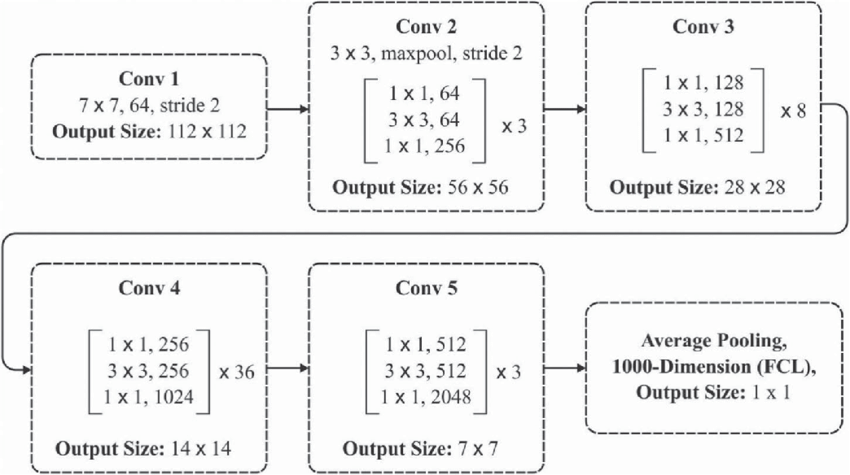

<style>
	div {
		text-align: justify
	}

  table {
      width: 100%;
      border-collapse: collapse;
      margin-bottom: 20px;
  }

  th, td {
      border: 1px solid #ddd;
      padding: 8px;
      text-align: left;
  }

  th {
      background-color: #f2f2f2;
  }

  h2, h3, h4, h5, h6 {
      font-weight: bold;
  }

  ul, ol {
      margin-top: 0;
  }

  img {
      max-width: 100%;
      height: auto;
      margin-bottom: 20px;
    }
</style>

<div>
  <h2> Kelebihan ResNet152</h2>
      <ul>
        <li>Memiliki arsitektur yang sangat dalam, mengatasi masalah vanishing gradient.</li>
        <li>Menggunakan blok residual, memudahkan pelatihan model.</li>
        <li>Secara umum memberikan kinerja yang baik pada tugas klasifikasi gambar.</li>
      </ul>

  <h2>Kekurangan ResNet152</h2>
      <ul>
        <li>Membutuhkan sumber daya komputasi yang besar dan waktu pelatihan yang lama.</li>
        <li>Lebih kompleks, sulit untuk diimplementasikan pada perangkat dengan sumber daya terbatas.</li>
      </ul>

  <h2> Grafik Training Loss </h2>
  <img src="plots\training_loss\ResNet_training_loss_plot.jpg" alt="ResNet152 Training Loss">

  <h3>Analisa Grafik Training Loss</h3>
  <ol>
    <li><b>Tren penurunan loss yang stabil:</b><br>
      Grafik loss ResNet152 menunjukkan tren penurunan yang stabil selama 20 epoch. Hal ini menunjukkan bahwa model ResNet152 belajar dengan baik dan mampu mengurangi error-nya dari waktu ke waktu.
    </li>
    <br>
    <li><b>Loss awal yang cukup rendah:</b><br>
      Loss awal ResNet152 sudah cukup rendah, yaitu sekitar 0.593. Hal ini menunjukkan bahwa model ResNet152 sudha mampu untuk mengklasifikasikan dataset BloodMNIST dengan cukup baik pada awalnya.
    </li>
    <br>
    <li><b>Penurunan loss yang cepat di awal pelatihan:</b><br>
      Penurunan loss ResNet152 paling signifikan terjadi di awal pelatihan (sampai epoch ke-5). Hal ini menunjukkan bahwa ResNet152 mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Penurunan loss yang lebih lambat di akhir pelatihan:</b><br>
      Penurunan loss ResNet152 menjadi lebih lambat di akhir pelatihan (epoch ke-5 hingga epoch ke-20). Hal ini menunjukkan bahwa ResNet152 semakin sulit untuk mengurangi error-nya seiring dengan semakin sulitnya data yang dihadapi.
    </li>
    <br>
    <li><b>Loss akhir yang rendah:</b><br>
      Loss akhir ResNet152 setelah 20 epoch adalah sekitar 0.042. Hal ini menunjukkan bahwa ResNet152 mampu mencapai akurasi yang tinggi dalam mengklasifikasikan dataset BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>

  <h2>Grafik Akurasi Training</h2>
  <img src="plots\training_accuracy\ResNet_training_accuracy_plot.jpg" alt="ResNet152 Training Accuracy">
  <h3>Analisa Grafik Akurasi Training</h3>
  <ol>
    <li><b>Tren peningkatan accuracy yang stabil:</b><br>
      Grafik training accuracy menunjukkan tren peningkatan yang stabil selama 20 epoch. Hal ini menunjukkan bahwa model ResNet152 mampu meningkatkan akurasinya dalam mengklasifikasikan dataset BloodMNIST dengan baik.
    </li>
    <br>
    <li><b>Accuracy awal yang tinggi:</b><br>
      Accuracy awal ResNet152 sudah cukup tinggi, yaitu 83.7%. Hal ini menunjukkan bahwa model ResNet152 sudah cukup mampu mengklasifikasikan dataset BloodMNIST dengan cukup baik sejak awal pelatihan.
    </li>
    <br>
    <li><b>Peningkatan accuracy yang cepat di awal pelatihan:</b><br>
      Peningkatan accuracy ResNet152 paling signifikan terjadi di awal pelatihan (sampai epoch ke-5). Hal ini menunjukkan bahwa ResNet152 mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Peningkatan accuracy yang lebih lambat di akhir pelatihan:</b><br>
      Peningkatan accuracy ResNet152 menjadi lebih lambat di akhir pelatihan (epoch ke-8 hingga epoch ke-20). Hal ini menunjukkan bahwa ResNet152 semakin sulit untuk meningkatkan akurasinya seiring dengan bertambahnya epoch.
    </li>
    <br>
    <li><b>Accuracy akhir yang sangat tinggi:</b><br>
      Accuracy akhir ResNet152 setelah 20 epoch adalah sekitar 98.4%. Hal ini menunjukkan bahwa ResNet152 mampu mencapai akurasi yang sangat tinggi dalam mengklasifikasikan dataset BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>
  <h2>Confusion Matrix</h2>
  <img src="confusion_matrix\ResNet152_confusion_matrix.jpg"  alt="ResNet152 Confusion Matrix">
  <h3>Analisa Confusion Matrix</h3>
	<ul>
		<li>
    Sama seperti VGG16 dan AlexNet, ResNet152 juga paling banyak salah prediksi sel monocyte sebagai immature granulocytes. Model ini memprediksi 31 monocyte sebagai immature granulocytes tetapi hanya memprediksi 11 immature granulocytes sebagai monocyte (lebih sedikit dibandingkan VGG16 dan AlexNet). Ini artinya bahwa model ResNet152 lebih mampu membedakan sel immature granulocytes dan monocyte. Tambahan lagi, model ini memprediksi 21 neutrophil sebagai immature granulocytes dan 10 immature granulocytes sebagai neutrophil. Maka sama seperti model-model sebelumnya yang telah saya analisa bahwa ResNet152 paling banyak gagal memprediksi monocyte dan neutrophil tetapi memprediksi monocyte dan neutrophil sebagai immature granulocytes.
    </li>
	</ul>

  <h2>Tabel Akurasi, Precision, Recall, F1, Best Epoch, Lowest Loss, Training Time</h2>
  <table>
      <thead>
          <tr>
              <th>Test Data Accuracy Score</th>
              <th>Test Data Precision Score</th>
              <th>Test Data Recall Score</th>
              <th>Test Data F1 Score</th>
              <th>Test Data Best Epoch</th>
              <th>Training Data Lowest Loss</th>
              <th>Total Training Time</th>
          </tr>
      </thead>
      <tbody>
        <tr>
            <td>95.8199%</td>
            <td>95.6497%</td>
            <td>95.1799%</td>
            <td>95.3404%</td>
            <td>18</td>
            <td>0.030</td>
            <td>19 hours, 14 minutes, 11 seconds</td>
        </tr>
  	</tbody>
  </table>

  <h3>Analisa Tabel</h3>
  <ol>
    <li><b>Test Data Accuracy Score (95.8199%):</b><br>
      Akurasi mengukur sejauh mana model mampu mengenali data uji dengan benar. Dengan nilai 95.8199%, model ResNet152 dapat mengklasifikasikan sekitar 95.82% data uji dengan benar.
    </li>
    <br>
    <li><b>Test Data Precision Score (95.6497%):</b><br>
      Presisi mengukur seberapa banyak dari instance yang diklasifikasikan sebagai positif oleh model yang benar-benar positif. Dengan angka 95.6497%, sekitar 95.65% dari semua instance yang diklasifikasikan sebagai positif benar-benar positif.
    </li>
    <br>
    <li><b>Test Data Recall Score (95.1799%):</b><br>
      Recall (sensitivitas) mengukur sejauh mana model dapat mengidentifikasi semua instance positif. Dengan persentase 95.1799%, model dapat mengenali sekitar 95.18% dari semua instance positif yang sebenarnya.
    </li>
    <br>
    <li><b>Test Data F1 Score (95.3404%):</b><br>
      Skor F1 adalah harmonic mean dari presisi dan recall. Dengan nilai 95.3404%, model mencapai keseimbangan yang baik antara presisi dan recall.
    </li>
    <br>
    <li><b>Test Data Best Epoch (18):</b><br>
      Best Epoch menunjukkan jumlah epoch ketika model mencapai kinerja terbaik pada data uji. Pada epoch ke-18, model ResNet152 mencapai performa terbaik.
    </li>
    <br>
    <li><b>Training Data Lowest Loss (0.030):</b><br>
      Ini adalah nilai loss terendah yang diperoleh selama pelatihan model. Loss mengukur seberapa baik model melakukan prediksi terhadap nilai sebenarnya. Dengan nilai 0.030, model ResNet152 memiliki performa pelatihan yang baik.
    </li>
    <br>
    <li><b>Total Training Time (19 hours, 14 minutes, 11 seconds):</b><br>
      Menyajikan waktu total yang dibutuhkan untuk melatih model ResNet152. Waktu ini mencakup seluruh proses pelatihan dari awal hingga akhir. Model ini melibatkan waktu pelatihan selama 19 jam, 14 menit, dan 11 detik, menunjukkan bahwa model ini melibatkan komputasi yang cukup intensif dan sangat lama. Namun, walaupun model ini memiliki waktu latih yang sangat lama, model ini mampu memberikan akurasi test yang tertinggi diantara 3 model lainnya.
    </li>
  </ol>
</div>

### GoogLeNet

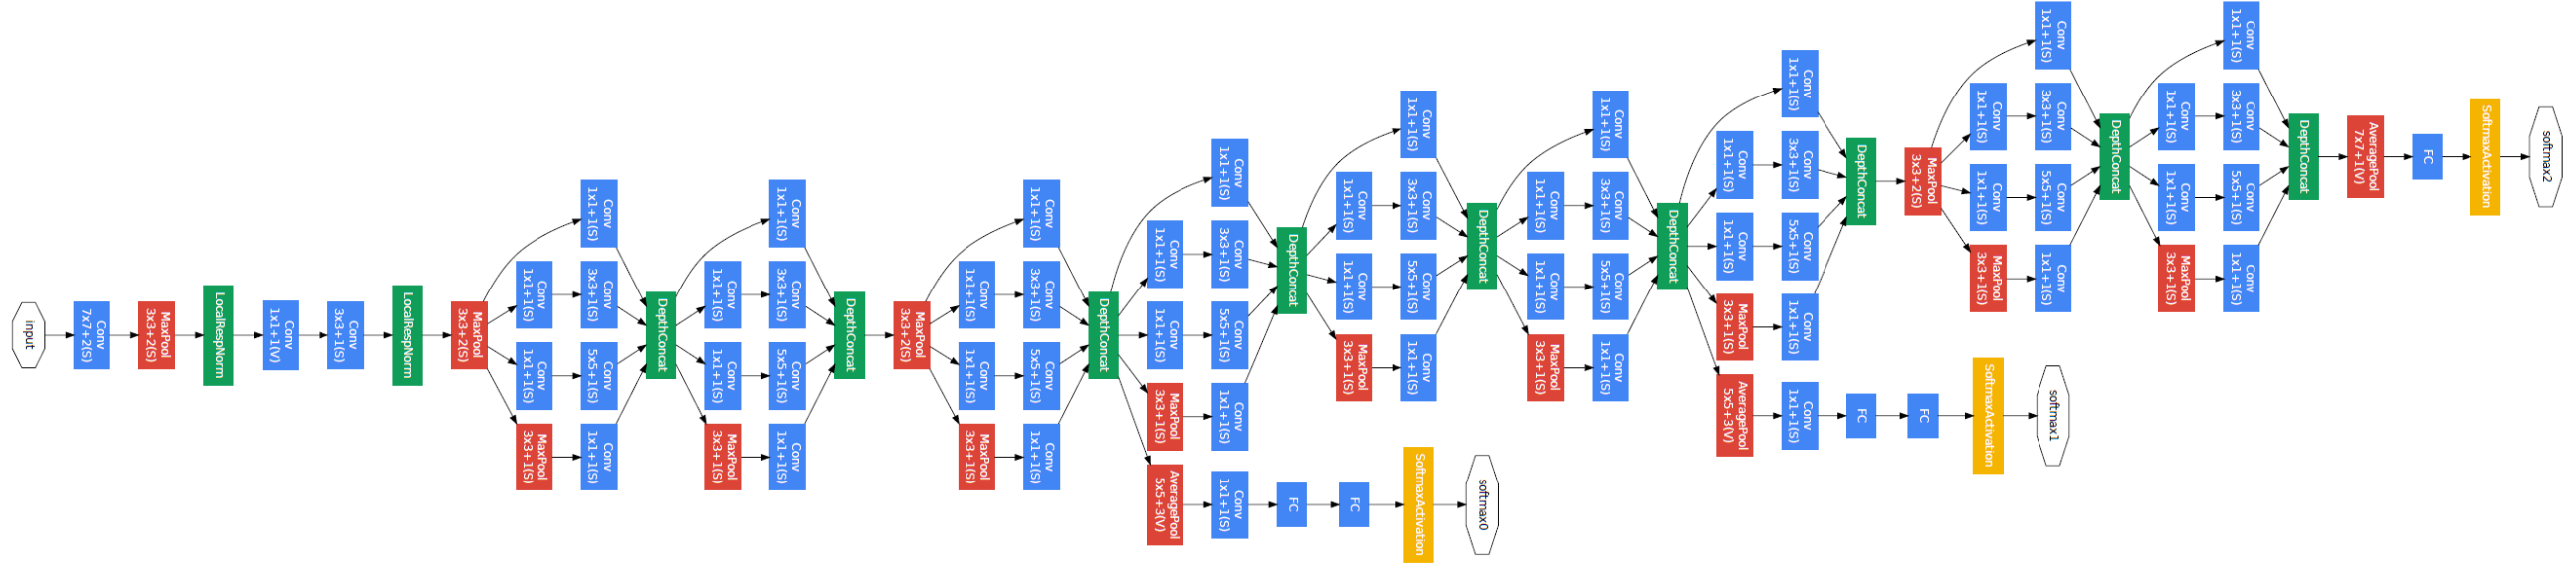

<style>
	div {
		text-align: justify
	}

  table {
      width: 100%;
      border-collapse: collapse;
      margin-bottom: 20px;
  }

  th, td {
      border: 1px solid #ddd;
      padding: 8px;
      text-align: left;
  }

  th {
      background-color: #f2f2f2;
  }

  h2, h3, h4, h5, h6 {
      font-weight: bold;
  }

  ul, ol {
      margin-top: 0;
  }

  img {
      max-width: 100%;
      height: auto;
      margin-bottom: 20px;
    }
</style>

<div>
  <h2> Kelebihan GoogLeNet</h2>
    <ul>
      <li>Menggunakan modul Inception, meningkatkan efisiensi komputasi.</li>
      <li>Relatif ringan dan efisien dalam penggunaan sumber daya.</li>
      <li>Mampu menangkap fitur pada berbagai skala.</li>
    </ul>

  <h2>Kekurangan GoogLeNet</h2>
    <ul>
      <li>Lebih sulit untuk diinterpretasikan karena kompleksitas arsitekturnya.</li>
      <li>Memerlukan tuning parameter yang hati-hati.</li>
    </ul>

  <h2> Grafik Training Loss </h2>
  <img src="plots\training_loss\GoogLeNet_training_loss_plot.jpg" alt="GoogLeNet Training Loss">

  <h3>Analisa Grafik Training Loss</h3>
  <ol>
    <li><b>Tren penurunan loss yang stabil:</b><br>
      Grafik loss GoogleNet menunjukkan tren penurunan yang stabil selama 20 epoch. Hal ini menunjukkan bahwa model GoogleNet belajar dengan baik dan mampu mengurangi error-nya dari waktu ke waktu.
    </li>
    <br>
    <li><b>Loss awal yang rendah:</b><br>
      Loss awal GoogleNet cukup rendah, yaitu 0.411. Hal ini menunjukkan bahwa model GoogleNet sudah cukup mampu untuk mengklasifikasikan dataset BloodMNIST pada awalnya.
    </li>
    <br>
    <li><b>Penurunan loss yang cepat di awal pelatihan:</b><br>
      Penurunan loss GoogleNet paling signifikan terjadi di awal pelatihan (sampai epoch ke-10). Hal ini menunjukkan bahwa GoogleNet mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Penurunan loss yang lebih lambat di akhir pelatihan:</b><br>
      Penurunan loss GoogleNet menjadi lebih lambat di akhir pelatihan (epoch ke-10 hingga epoch ke-20). Hal ini menunjukkan bahwa GoogleNet semakin sulit untuk mengurangi error-nya seiring dengan semakin sulitnya data yang dihadapi.
    </li>
    <br>
    <li><b>Loss akhir yang rendah:</b><br>
      Loss akhir GoogleNet setelah 20 epoch adalah sekitar 0.035. Hal ini menunjukkan bahwa GoogleNet mampu mencapai akurasi yang sangat tinggi dalam mengklasifikasikan dataset BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>
  <h2>Grafik Akurasi Training</h2>
  <img src="plots\training_accuracy\GoogLeNet_training_accuracy_plot.jpg" alt="GoogLeNet Training Accuracy">
  <h3>Analisa Grafik Akurasi Training</h3>
  <ol>
    <li><b>Tren peningkatan accuracy yang stabil:</b><br>
      Grafik training accuracy GoogleNet menunjukkan tren peningkatan yang stabil selama 20 epoch. Hal ini menunjukkan bahwa model GoogleNet mampu meningkatkan akurasinya dalam mengklasifikasikan dataset BloodMNIST dengan baik.
    </li>
    <br>
    <li><b>Accuracy awal yang cukup tinggi:</b><br>
      Accuracy awal GoogleNet sudah cukup tinggi, yaitu sekitar 88.1%. Hal ini menunjukkan bahwa model GoogleNet mampu mengklasifikasikan dataset BloodMNIST dengan sangat baik sejak awal pelatihan.
    </li>
    <br>
    <li><b>Peningkatan accuracy yang cepat di awal pelatihan:</b><br>
      Peningkatan accuracy GoogleNet paling signifikan terjadi di awal pelatihan (sampai epoch ke-5). Hal ini menunjukkan bahwa GoogleNet mampu belajar dengan cepat pada fase awal pelatihan.
    </li>
    <br>
    <li><b>Peningkatan accuracy yang lebih lambat di akhir pelatihan:</b><br>
      Peningkatan accuracy GoogleNet menjadi lebih lambat di akhir pelatihan (epoch ke-5 hingga epoch ke-20). Hal ini menunjukkan bahwa GoogleNet semakin sulit untuk meningkatkan akurasinya seiring dengan bertambahnya.
    </li>
    <br>
    <li><b>Accuracy akhir yang sangat tinggi:</b><br>
      Accuracy akhir GoogleNet setelah 20 epoch adalah sekitar 98.7%. Hal ini menunjukkan bahwa GoogleNet mampu mencapai akurasi yang sangat tinggi (paling tinggi diantara tiga model lainnya) dalam mengklasifikasikan dataset BloodMNIST setelah dilatih selama 20 epoch.
    </li>
  </ol>
  <h2>Confusion Matrix</h2>
  <img src="confusion_matrix\GoogLeNet_confusion_matrix.jpg"  alt="GoogLeNet Confusion Matrix">
  <h3>Analisa Confusion Matrix</h3>
	<ul>
		<li>Model GoogLeNet paling banyak salah prediksi immature granulocytes sebagai monocyte (mirip seperti model-model sebelumnya). GoogLeNet memprediksi 27 immature granulocytes sebagai monocyte. Tidak hanya itu, model ini juga cukup banyak salah memprediksi neutrophil sebagai immature granulocytes (mirip seperti model ResNet152). Model ini memprediksi 23 neutrophil sebagai immature granulocytes.
    </li>
	</ul>

  <h2>Tabel Akurasi, Precision, Recall, F1, Best Epoch, Lowest Loss, Training Time</h2>
  <table>
      <thead>
          <tr>
              <th>Test Data Accuracy Score</th>
              <th>Test Data Precision Score</th>
              <th>Test Data Recall Score</th>
              <th>Test Data F1 Score</th>
              <th>Test Data Best Epoch</th>
              <th>Training Data Lowest Loss</th>
              <th>Total Training Time</th>
          </tr>
      </thead>
      <tbody>
        <tr>
            <td>95.6153%</td>
            <td>94.7455%</td>
            <td>95.1773%</td>
            <td>94.8394%</td>
            <td>17</td>
            <td>0.032</td>
            <td>1 hours, 51 minutes, 35 seconds</td>
        </tr>
  	</tbody>
  </table>

  <h3>Analisa Tabel</h3>
  <ol>
    <li><b>Test Data Accuracy Score (95.6153%):</b><br>
      Akurasi mengukur sejauh mana model mampu mengenali data uji dengan benar. Nilai 95.6153% menunjukkan bahwa model GoogLeNet dapat mengklasifikasikan sekitar 95.62% data uji dengan benar.
    </li>
    <br>
    <li><b>Test Data Precision Score (94.7455%):</b><br>
      Presisi mengukur seberapa banyak dari instance yang diklasifikasikan sebagai positif oleh model yang benar-benar positif. Dengan angka 94.7455%, sekitar 94.75% dari semua instance yang diklasifikasikan sebagai positif benar-benar positif.
    </li>
    <br>
    <li><b>Test Data Recall Score (95.1773%):</b><br>
      Recall (sensitivitas) mengukur sejauh mana model dapat mengidentifikasi semua instance positif. Dengan persentase 95.1773%, model dapat mengenali sekitar 95.18% dari semua instance positif yang sebenarnya.
    </li>
    <br>
    <li><b>Test Data F1 Score (94.8394%):</b><br>
      Skor F1 adalah harmonic mean dari presisi dan recall. Dengan nilai 94.8394%, model mencapai keseimbangan yang baik antara presisi dan recall.
    </li>
    <br>
    <li><b>Test Data Best Epoch (17):</b><br>
      Best Epoch menunjukkan jumlah epoch ketika model mencapai kinerja terbaik pada data uji. Pada epoch ke-17, model mencapai performa terbaik.
    </li>
    <br>
    <li><b>Training Data Lowest Loss (0.032):</b><br>
      Ini adalah nilai loss terendah yang diperoleh selama pelatihan model. Loss mengukur seberapa baik model melakukan prediksi terhadap nilai sebenarnya.
    </li>
    <br>
    <li><b>Total Training Time (1 hours, 51 minutes, 35 seconds):</b><br>
      Menyajikan waktu total yang dibutuhkan untuk melatih model GoogLeNet. Waktu ini mencakup seluruh proses pelatihan dari awal hingga akhir. Waktu ini relatif cepat dibandingkan dengan VGG dan ResNet152 namun masih lebih lambat dari AlexNet. Meskipun demikian, model ini memiliki testing akurasi kedua, lowest epoch loss kedua tertinggi dibandingkan dengan ketiga model lainnya dengan waktu yang cukup rendah.
    </li>
  </ol>
</div>

# Kesimpulan

<style>
	div {
		text-align: justify
	}

  ul, ol {
      margin-top: 0;
  }

</style>

<div>
    <ol>
        <li>Model yang memiliki testing accuracy, precision, F1 Score, dan lowest training loss terbaik adalah <b>ResNet152</b>. Namun, tradeoff dari hasil yang sangat baik ini adalah waktu training yang sangat lama yaitu 19 jam.
        </li>
        <br>
        <li>Model terburuk untuk mengklasifikasi BloodMNIST dataset adalah <b>VGG16</b> karena memiliki testing accuracy, precision, F1 Score, dan lowest training loss yang terendah diantara ketiga model lainnya dan memiliki waktu training kedua terlama yaitu selama 11 jam.
        </li>
        <br>
        <li>Model terbaik untuk mengklasifikasi BloodMNIST dataset adalah <b>GoogLeNet </b> karena memiliki nilai testing accuracy, precision, F1 Score yang sangat tinggi walaupun masih sedikit lebih rendah dari ResNet152. Namun, model ini training nya jauh lebih cepat dibandingkan dengan ResNet152 dan mencapai hasil yang serupa.
        </li>
        <br>
        <li><b>AlexNet</b> merupakan model ketiga tertinggi yang memiliki nilai testing accuracy, precision, F1 Score tertinggi dan merupakan model dengan training time yang sangat cepat yaitu sebesar 13 menit saja untuk 20 epoch. Maka dari itu, AlexNet sangat cocok digunakan jika ingin mendapatkan hasil yang cukup baik dengan waktu yang terbatas.
        </li>
    </ol>
</div>